In [1]:
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, sqlite3, pickle, time, datetime, random

pd.set_option('display.float_format', lambda x: '%.3f' % x)

# 0. Load Data

In [2]:
data = pickle.load( open('DataFrame_pickles/df_patients_admissions_v3.pickle', 'rb'))
df_patients   = data[0]
df_admissions = data[1]
data = pickle.load( open('DataFrame_pickles/df_haematology_v1.pickle', 'rb'))
df_haematology_old = data[0]
df_haematology_new = pickle.load( open("DataFrame_pickles/new_haematology_3d.pickle", 'rb'))

list_admissions      = df_admissions['admission_id'].unique().tolist()

In [3]:
len(df_admissions[df_admissions['lengthofstay'] < datetime.timedelta(days= 3)])

2915

In [4]:
df_admissions

,admission_id,episode_diagnoses,patient_id,age_at_admission\r,admission_date_time,admission_date_code_time,discharge_date_time,discharge_date_code_time,lengthofstay,isPneumonia,mortal_admin,icu_count\r,Comorbidity_score,no_obs_eobs,no_haematology_eobs
3,99645131,"||E10.5,L97.X,L08.9,R02.X,A41.9,R65.1,N17.9,E1...",18026138,55,2021-11-25 16:34:00,18956.690,2021-12-31 14:48:00,18992.617,35 days 22:14:00,1,0,0,2,169,19
4,21362780,"||U07.1,J12.8,B97.2,J15.9,B97.2,Z86.7||U07.1,J...",27754209,45,2021-11-12 17:21:00,18943.723,2021-11-20 14:00:00,18951.583,7 days 20:39:00,1,0,0,0,42,3
5,13991116,"||A41.9,U07.1,J12.8,B97.2,K75.0,K92.0,J90.X,I8...",54047888,70,2020-04-20 21:48:00,18372.908,2020-05-20 05:30:00,18402.229,29 days 07:42:00,1,1,0,1,210,29
6,58580641,"||U07.2,J12.8,E11.9,Z86.1",56373663,66,2020-05-21 08:05:00,18403.337,2020-05-21 15:07:00,18403.630,0 days 07:02:00,1,0,0,1,7,0
8,69545615,"||J18.1,J45.9,C91.1,D64.9,Z93.6,H54.0||J18.1,J...",995938,77,2020-02-11 06:08:00,18303.256,2020-02-21 20:00:00,18313.833,10 days 13:52:00,1,0,0,1,43,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24712,31522839,"||J18.9,R79.8",67793747,29,2021-03-17 16:28:00,18703.686,2021-03-17 21:07:00,18703.880,0 days 04:39:00,1,0,0,0,2,0
24714,45724066,"||U07.1,J12.8,B97.2,E66.9,Z88.0,Z20.8||U07.1,J...",36563881,44,2021-02-15 21:46:00,18673.907,2021-02-23 14:30:00,18681.604,7 days 16:44:00,1,0,0,0,39,4
24715,59159274,"||U07.1,J12.8,B97.2,J45.9,G47.3,K44.9,Z93.2,E6...",81423412,50,2021-07-24 15:02:00,18832.626,2021-07-27 17:30:00,18835.729,3 days 02:28:00,1,0,0,0,31,1
24716,80986711,"||I48.9,R00.0,I10.X||I48.9,R00.0,I10.X||I48.9,...",14300288,87,2020-02-05 10:56:00,18297.456,2020-02-10 17:41:00,18302.737,5 days 06:45:00,1,0,0,4,29,2


# 1. Data Check

### 1.1. Admissions

In [5]:
print('Admissions in admissions', len(df_admissions))
print('')

print('Admissions in Haematology_old', len(df_haematology_old['admission_id'].unique()))
print('Admissions in Haematology_new', len(df_haematology_new['admission_id'].unique()))

Admissions in admissions 14714

Admissions in Haematology_old 11174
Admissions in Haematology_new 8258


### 1.2. Null Checks

In [6]:
df = pd.concat([df_haematology_old.isna().sum(), df_haematology_new.dtypes], axis=1)
df = df.rename(columns ={0:'nulls',1:'type'})
df['null%'] = 100* df['nulls']/len(df_haematology_old)
display(df.sort_values(by=['null%']))
display(df_haematology_old.describe())

,nulls,type,null%
admission_id,0,object,0.000
sample_collection_date_time,0,object,0.000
CREA,6013,object,6.176
UREA,6016,object,6.180
K,6242,object,6.412
GFR,6513,object,6.690
EGFR,6670,object,6.851
MCH,11579,object,11.894
RBC,11579,object,11.894
HGB,11580,object,11.895


,admission_id,CREA,UREA,K,EGFR,GFR,WBC,PLT,HCT,HGB,...,MCH,MCV,NEUAB,TLYMAB,EOSAB,MONAB,BASAB,ALB,ALP,BILI
count,97353.000,91340.000,91337.000,91111.000,90683.000,90840.000,85748.000,85575.000,85770.000,85773.000,...,85774.000,85640.000,82379.000,82371.000,82371.000,82347.000,82282.000,72798.000,72661.000,67469.000
mean,49875893.100,110.771,10.236,4.312,66.921,68.943,10.845,281.967,0.347,112.041,...,29.379,90.909,8.372,1.279,0.156,0.584,0.041,34.289,125.164,12.651
std,28704811.530,103.648,6.878,0.700,25.302,24.874,6.225,148.900,0.068,22.416,...,2.845,7.802,4.444,0.805,0.205,0.317,0.035,5.993,81.495,10.750
min,13004.000,20.000,0.900,2.000,20.000,20.000,3.000,90.000,0.200,70.000,...,20.000,70.000,0.500,0.300,0.000,0.005,0.000,20.000,30.000,1.998
25%,25293001.000,57.000,5.400,3.900,46.000,49.000,6.900,173.000,0.295,95.000,...,27.900,86.000,5.110,0.760,0.030,0.380,0.020,30.000,74.000,6.000
50%,49480832.000,77.000,8.100,4.300,78.000,82.000,9.600,254.000,0.343,110.000,...,29.500,91.000,7.530,1.120,0.090,0.530,0.030,34.000,99.000,9.000
75%,74415776.000,117.000,12.800,4.700,90.001,90.001,13.200,359.000,0.395,128.000,...,31.000,95.000,10.800,1.600,0.210,0.730,0.050,38.000,144.000,15.000
max,99995341.000,600.000,30.000,7.000,90.001,90.001,55.000,800.000,0.750,200.000,...,42.000,120.000,20.000,7.000,1.600,2.500,0.500,70.000,400.000,50.000


In [7]:
df = pd.concat([df_haematology_new.isna().sum(), df_haematology_new.dtypes], axis=1)
df = df.rename(columns ={0:'nulls',1:'type'})
df['null%'] = 100* df['nulls']/len(df_haematology_new)
display(df.sort_values(by=['null%']))
display(df_haematology_new.describe())

,nulls,type,null%
admission_id,0,object,0.000
WBC,0,object,0.000
K,0,object,0.000
HGB,0,object,0.000
CREA,0,object,0.000
UREA,0,object,0.000
sample_collection_date_time,0,object,0.000
MCV,12,object,0.012
RBC,12,object,0.012
MCH,12,object,0.012


,admission_id,sample_collection_date_time,CREA,UREA,K,EGFR,GFR,WBC,PLT,HCT,...,MCH,MCV,NEUAB,TLYMAB,EOSAB,MONAB,BASAB,ALB,ALP,BILI
count,99096,99096,99096.000,99096.000,99096.000,99012.000,99012.000,99096.000,99024.000,99084.000,...,99084.000,99084.000,98076.000,98064.000,98064.000,98040.000,98028.000,97668.000,97656.000,97068.000
unique,8258,2813,12603.000,16265.000,4847.000,8125.000,8182.000,16854.000,20028.000,18412.000,...,12708.000,4519.000,38239.000,18190.000,7902.000,11689.000,3255.000,3915.000,11136.000,5018.000
top,1671170,2021-01-19 12:00:00,330.000,30.000,4.200,90.001,90.001,3.000,90.000,0.365,...,29.500,90.000,15.000,0.300,0.010,1.200,0.020,38.000,200.000,6.000
freq,12,85,2731.000,1790.000,2802.000,22829.000,28747.000,1804.000,4032.000,264.000,...,697.000,2676.000,6168.000,1546.000,7356.000,2561.000,10014.000,3546.000,6386.000,4389.000


In [8]:
df_haematology_new.head(25)

,admission_id,sample_collection_date_time,CREA,UREA,K,EGFR,GFR,WBC,PLT,HCT,...,MCH,MCV,NEUAB,TLYMAB,EOSAB,MONAB,BASAB,ALB,ALP,BILI
0,1671170,2020-03-31 00:00:00,59.000,15.500,4.400,90.001,90.001,11.300,293.000,0.414,...,29.400,91.000,7.560,2.500,0.230,0.960,0.060,41.000,112.000,4.000
1,1671170,2020-03-31 06:00:00,59.200,15.360,4.420,90.001,90.001,11.400,290.600,0.416,...,29.380,91.000,7.678,2.466,0.238,0.958,0.058,40.400,112.200,4.200
2,1671170,2020-03-31 12:00:00,59.400,15.220,4.440,90.001,90.001,11.500,288.200,0.419,...,29.360,91.000,7.796,2.432,0.246,0.956,0.056,39.800,112.400,4.400
3,1671170,2020-03-31 18:00:00,59.600,15.080,4.460,90.001,90.001,11.600,285.800,0.421,...,29.340,91.000,7.914,2.398,0.254,0.954,0.054,39.200,112.600,4.600
4,1671170,2020-04-01 00:00:00,59.800,14.940,4.480,90.001,90.001,11.700,283.400,0.424,...,29.320,91.000,8.032,2.364,0.262,0.952,0.052,38.600,112.800,4.800
5,1671170,2020-04-01 06:00:00,60.000,14.800,4.500,90.001,90.001,11.800,281.000,0.426,...,29.300,91.000,8.150,2.330,0.270,0.950,0.050,38.000,113.000,5.000
6,1671170,2020-04-01 12:00:00,58.333,14.389,4.500,90.001,90.001,11.578,275.333,0.423,...,29.333,90.889,8.011,2.289,0.282,0.906,0.050,37.667,111.222,5.111
7,1671170,2020-04-01 18:00:00,56.667,13.978,4.500,90.001,90.001,11.356,269.667,0.421,...,29.367,90.778,7.872,2.248,0.294,0.861,0.050,37.333,109.444,5.222
8,1671170,2020-04-02 00:00:00,55.000,13.567,4.500,90.001,90.001,11.133,264.000,0.418,...,29.400,90.667,7.733,2.207,0.307,0.817,0.050,37.000,107.667,5.333
9,1671170,2020-04-02 06:00:00,53.333,13.156,4.500,90.001,90.001,10.911,258.333,0.415,...,29.433,90.556,7.594,2.166,0.319,0.772,0.050,36.667,105.889,5.444


In [9]:
import random
import matplotlib
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import matplotlib.pyplot as plt

In [10]:
dict_labels = {'rr':'Respiratory rate','ews':'EWS','heart_rate':'Heart rate','temperature\r':'Temperature',
               'sbp':'Systolic bp','dbp':'Diastolic bp','Oxygen_Saturation':'Oxygen Saturation','Assisted_O2':'Assisted O2',
               'Confusion':'Confusion','CREA':'Creatinine','UREA':'Urea','K':'Potassium', 'GFR':'GFR', 'EGFR':'GFR','WBC':'WBC',
               'PLT':'Platelets','HCT':'HCT','HGB':'Haemoglobin','RBC':'RBC','MCH':'MCH','MCV':'MCV','NEUAB':'Neutrophil Ab',
               'TLYMAB':'T-lymphocite Ab','EOSAB':'EOS Ab','MONAB':'Monocyte Ab','BASAB':'Anti Basophil Ab','ALB':'Albumin',
               'ALP':'Alk. Phosphate','BILI':'Bilirubin','sex':'Sex','ethnicity':'Ethnicity','had_Prev_admin':'Prev. admission',
               'age_at_admin':'Age at admission','Comorb_score':'Charlson comorbid.','Spcfc_Comorb':'Resp. Comorbidity'}


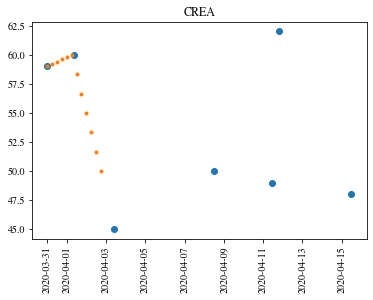

In [11]:
adm_no = 1671170
field = 'CREA'
adm_new = df_haematology_new[df_haematology_new['admission_id'] == adm_no]
adm_old = df_haematology_old[df_haematology_old['admission_id'] == adm_no]

plt.plot(adm_old['sample_collection_date_time'],adm_old[field], 'o')
plt.plot(adm_new['sample_collection_date_time'],adm_new[field], '.')
plt.title(field)
plt.xticks(rotation = 90)
plt.show()

In [12]:
df_haematology_new[df_haematology_new['admission_id'] == adm_no]

,admission_id,sample_collection_date_time,CREA,UREA,K,EGFR,GFR,WBC,PLT,HCT,...,MCH,MCV,NEUAB,TLYMAB,EOSAB,MONAB,BASAB,ALB,ALP,BILI
0,1671170,2020-03-31 00:00:00,59.000,15.500,4.400,90.001,90.001,11.300,293.000,0.414,...,29.400,91.000,7.560,2.500,0.230,0.960,0.060,41.000,112.000,4.000
1,1671170,2020-03-31 06:00:00,59.200,15.360,4.420,90.001,90.001,11.400,290.600,0.416,...,29.380,91.000,7.678,2.466,0.238,0.958,0.058,40.400,112.200,4.200
2,1671170,2020-03-31 12:00:00,59.400,15.220,4.440,90.001,90.001,11.500,288.200,0.419,...,29.360,91.000,7.796,2.432,0.246,0.956,0.056,39.800,112.400,4.400
3,1671170,2020-03-31 18:00:00,59.600,15.080,4.460,90.001,90.001,11.600,285.800,0.421,...,29.340,91.000,7.914,2.398,0.254,0.954,0.054,39.200,112.600,4.600
4,1671170,2020-04-01 00:00:00,59.800,14.940,4.480,90.001,90.001,11.700,283.400,0.424,...,29.320,91.000,8.032,2.364,0.262,0.952,0.052,38.600,112.800,4.800
5,1671170,2020-04-01 06:00:00,60.000,14.800,4.500,90.001,90.001,11.800,281.000,0.426,...,29.300,91.000,8.150,2.330,0.270,0.950,0.050,38.000,113.000,5.000
6,1671170,2020-04-01 12:00:00,58.333,14.389,4.500,90.001,90.001,11.578,275.333,0.423,...,29.333,90.889,8.011,2.289,0.282,0.906,0.050,37.667,111.222,5.111
7,1671170,2020-04-01 18:00:00,56.667,13.978,4.500,90.001,90.001,11.356,269.667,0.421,...,29.367,90.778,7.872,2.248,0.294,0.861,0.050,37.333,109.444,5.222
8,1671170,2020-04-02 00:00:00,55.000,13.567,4.500,90.001,90.001,11.133,264.000,0.418,...,29.400,90.667,7.733,2.207,0.307,0.817,0.050,37.000,107.667,5.333
9,1671170,2020-04-02 06:00:00,53.333,13.156,4.500,90.001,90.001,10.911,258.333,0.415,...,29.433,90.556,7.594,2.166,0.319,0.772,0.050,36.667,105.889,5.444


In [13]:
df_haematology_old[df_haematology_old['admission_id'] == adm_no]

,admission_id,sample_collection_date_time,CREA,UREA,K,EGFR,GFR,WBC,PLT,HCT,...,MCH,MCV,NEUAB,TLYMAB,EOSAB,MONAB,BASAB,ALB,ALP,BILI
75,1671170,2020-03-31 00:10:00,59.000,15.500,4.400,90.001,90.001,11.300,293.000,0.414,...,29.400,91.000,7.560,2.500,0.230,0.960,0.060,41.000,112.000,4.000
76,1671170,2020-04-01 08:22:00,60.000,14.800,4.500,90.001,90.001,11.800,281.000,0.426,...,29.300,91.000,8.150,2.330,0.270,0.950,0.050,38.000,113.000,5.000
77,1671170,2020-04-03 09:44:00,45.000,11.100,4.500,90.001,90.001,9.800,230.000,0.402,...,29.600,90.000,6.900,1.960,0.380,0.550,0.050,35.000,97.000,6.000
78,1671170,2020-04-08 12:17:00,50.000,9.700,4.900,90.001,90.001,15.300,329.000,0.444,...,28.500,88.000,12.070,2.250,0.340,0.580,0.030,NaN,NaN,NaN
79,1671170,2020-04-11 10:22:00,49.000,7.900,4.700,90.001,90.001,11.000,318.000,0.412,...,28.200,89.000,7.840,2.180,0.180,0.790,0.040,NaN,NaN,NaN
80,1671170,2020-04-11 19:41:00,62.000,9.200,5.000,90.001,90.001,17.300,330.000,0.440,...,28.000,89.000,14.600,1.690,0.060,0.870,0.050,NaN,NaN,NaN
81,1671170,2020-04-15 11:53:00,48.000,5.100,4.700,90.001,90.001,9.100,280.000,0.386,...,28.200,89.000,5.840,2.010,0.380,0.800,0.040,NaN,NaN,NaN


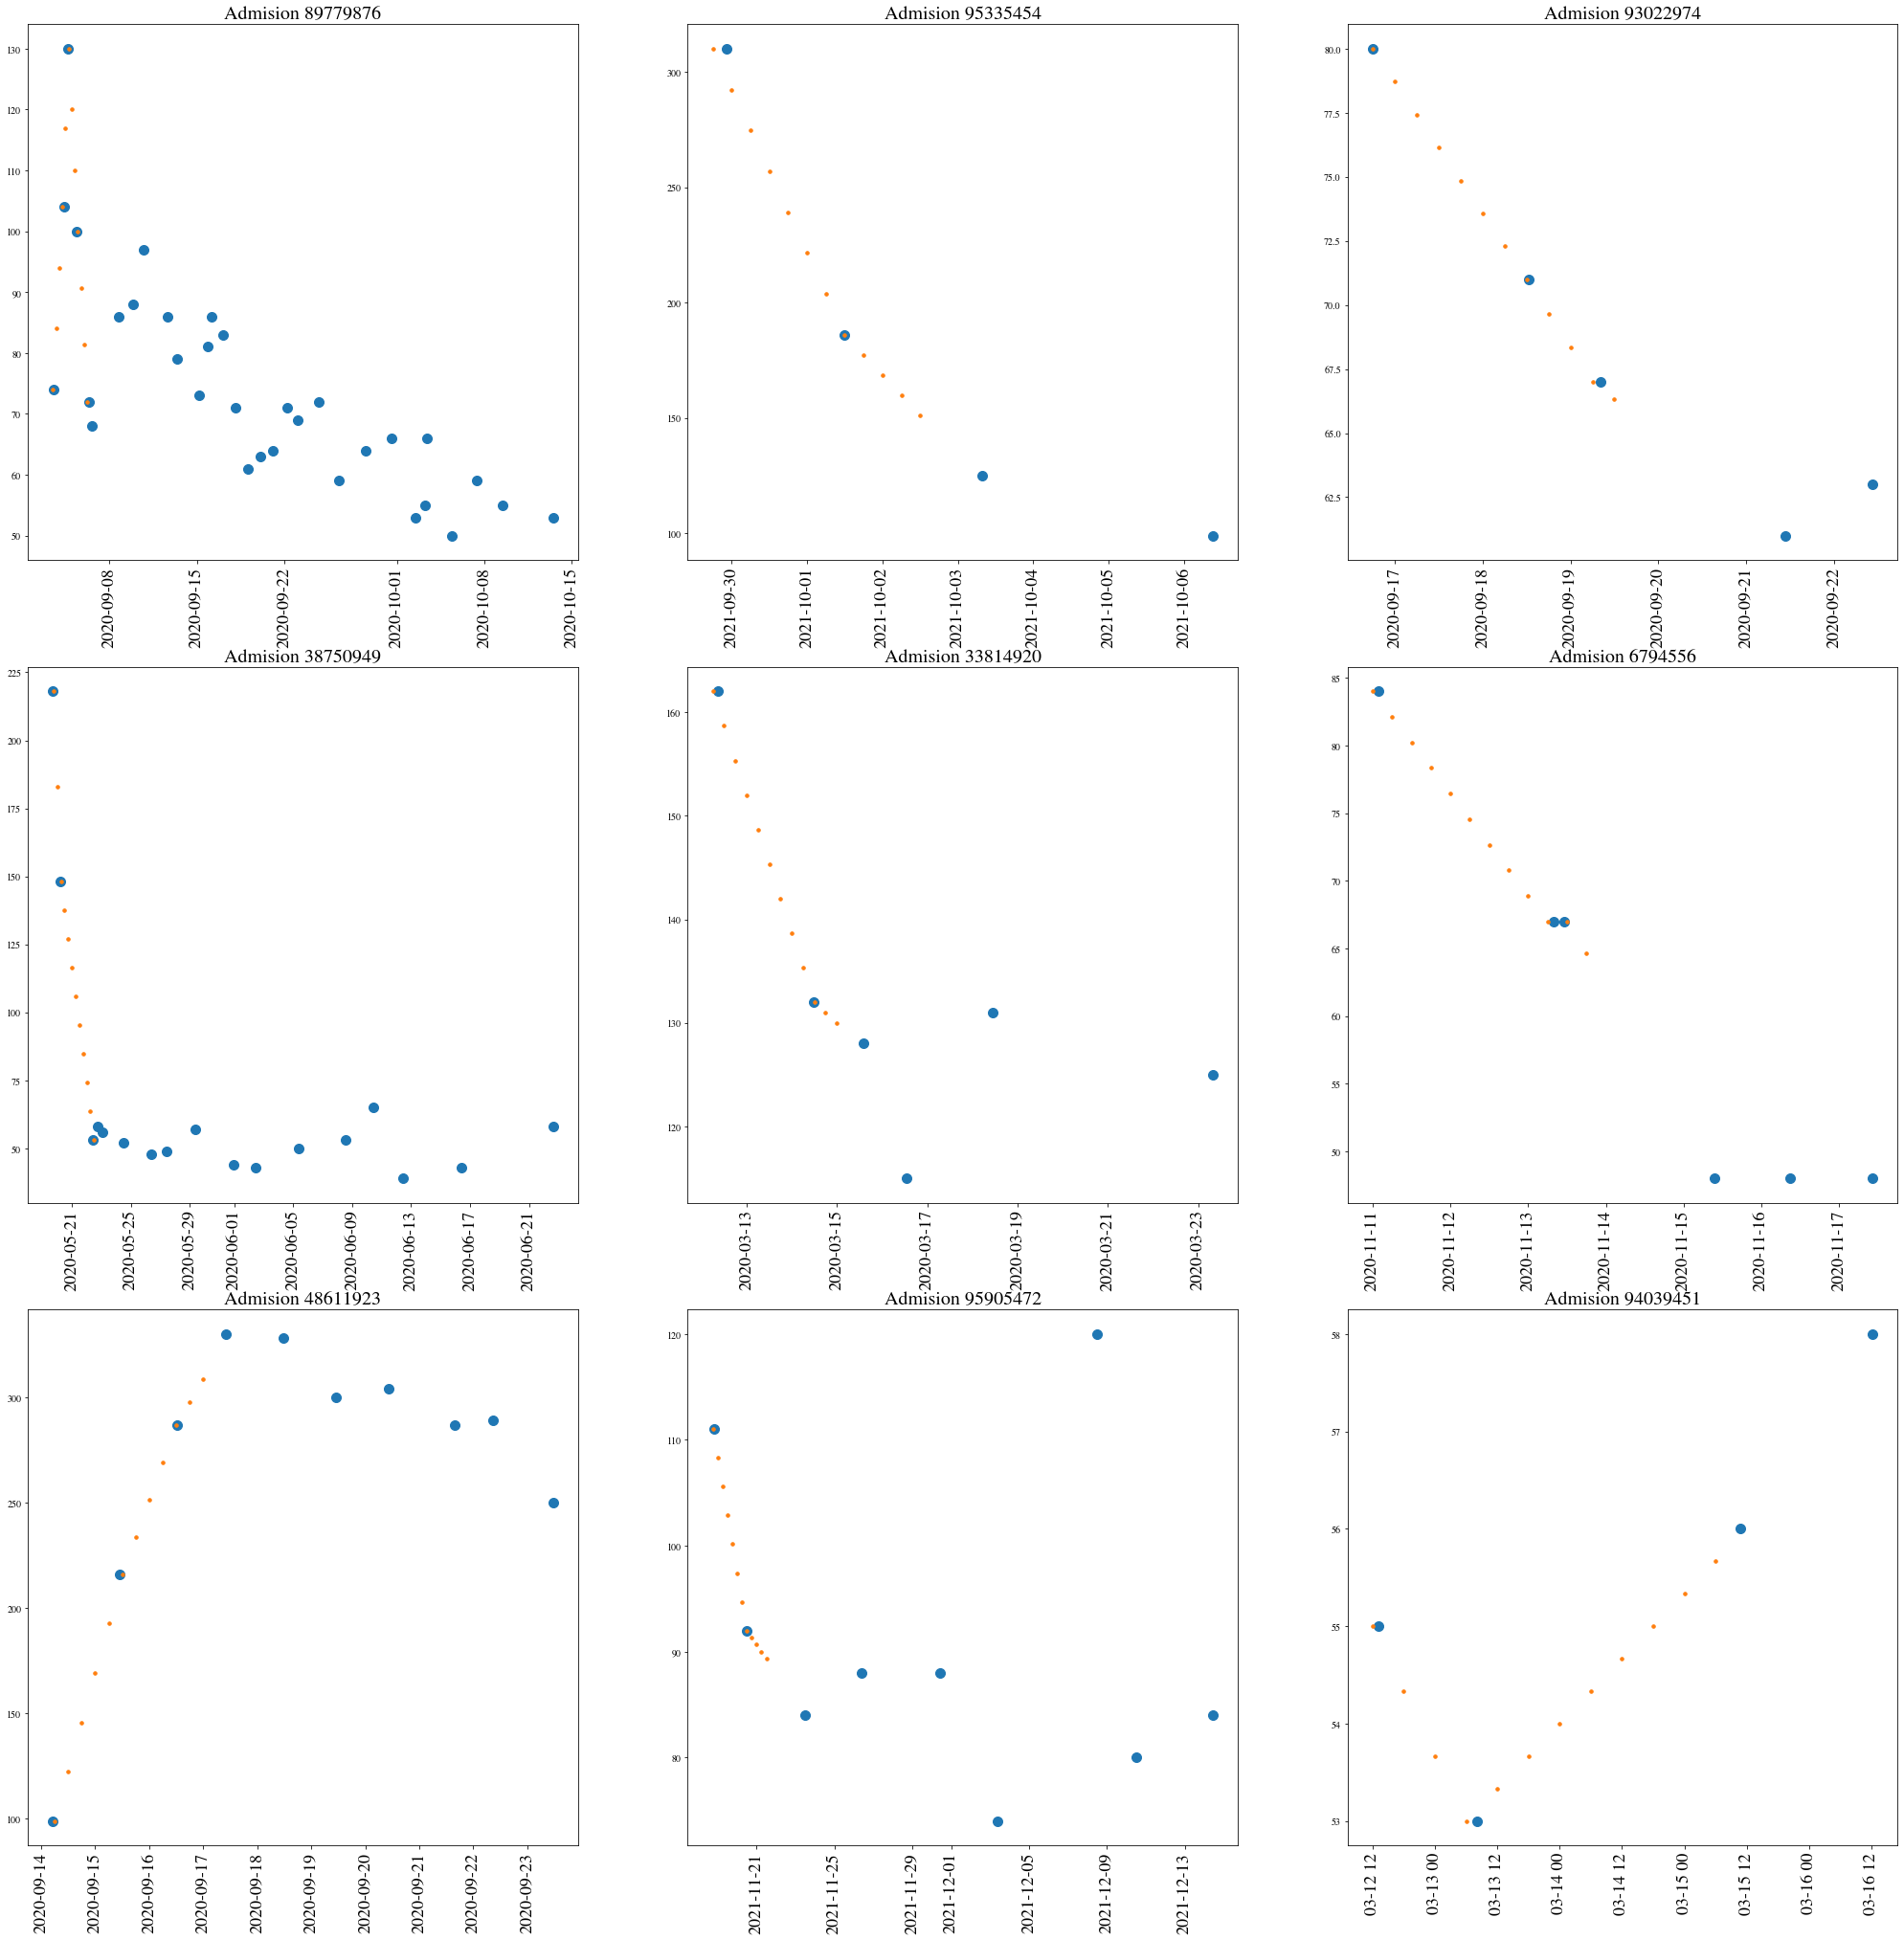

In [14]:
fig = plt.figure(figsize = (35,35))
n_plots = 9
admns = df_haematology_new['admission_id'].unique().tolist()
idx_adm = random.sample(range(len(admns)), n_plots)


for i, idx in enumerate(idx_adm):
    adm_no = admns[idx]
    
    adm_new = df_haematology_new[df_haematology_new['admission_id'] == adm_no]
    adm_old = df_haematology_old[df_haematology_old['admission_id'] == adm_no]
    
    ax = fig.add_subplot(3, 3, i+1)
    
    plt.plot(adm_old['sample_collection_date_time'],adm_old[field], 'o', markersize =10, label = 'Original')
    plt.plot(adm_new['sample_collection_date_time'],adm_new[field], '.', markersize =7, label = 'Interpolation')
    ax.set_title('Admision ' + str(adm_no), fontsize = 20)
    ax.tick_params(axis = 'x',rotation = 90, labelsize = 18)
    plt.savefig(r'Images/Valid_InterpolationHaemTotalResults_'+ str(adm_no) +'.png', transparent = True, bbox_inches = "tight")
plt.show()

In [15]:
dct_lbl_1 = {'CREA':'Creatinine','UREA':'Urea','K':'Potassium', 'GFR':'GFR', 'WBC':'WBC', 'PLT':'Platelets'}#,'HCT':'HCT'}
               
dct_lbl_2 = {'HGB':'Haemoglobin','RBC':'RBC','MCH':'MCH','MCV':'MCV','NEUAB':'Neutrophil Ab','TLYMAB':'T-lymphocite Ab'}
                
dct_lbl_3 = {'EOSAB':'EOS Ab','MONAB':'Monocyte Ab','BASAB':'Anti Basophil Ab','ALB':'Albumin',
               'ALP':'Alk. Phosphate','BILI':'Bilirubin'}

def plot_eobs_admin(adm_no, dictionary_labels, save = False):
    adm_new = df_haematology_new[df_haematology_new['admission_id'] == adm_no]
    adm_old = df_haematology_old[(df_haematology_old['admission_id'] == adm_no) &
                         (df_haematology_old['sample_collection_date_time'] <= adm_new['sample_collection_date_time'].max())]

    
    fig = plt.figure(figsize = (35,8))
    for i,field in enumerate(dictionary_labels.keys()):
        ax = fig.add_subplot(1,6 , i+1)

        ax.plot(adm_new['sample_collection_date_time'],adm_new[field], '.-', label = 'Interpolation')
        
        ax.plot(adm_old['sample_collection_date_time'],adm_old[field], 'o', label = 'Original', markersize =10)

        #ax.set_title(field, fontsize = 17)
        fig.text(0.09, 0.5, 'admission ' + str(adm_no), va='center', rotation='vertical', fontsize = 30)
        ax.tick_params(axis = 'x',rotation = 90, labelsize = 20)
        ax.tick_params(axis = 'y', labelsize = 20)
    if list(dictionary_labels.keys())[0] == 'CREA':
        fig.text(0.17, 0.95, list(dictionary_labels.keys())[0], va='center', fontsize = 30)
        fig.text(0.295, 0.95,  list(dictionary_labels.keys())[1], va='center', fontsize = 30)
        fig.text(0.44, 0.95, list(dictionary_labels.keys())[2], va='center', fontsize = 30)
        fig.text(0.565, 0.95, list(dictionary_labels.keys())[3], va='center', fontsize = 30)
        fig.text(0.70, 0.95, list(dictionary_labels.keys())[4], va='center', fontsize = 30)
        fig.text(0.83, 0.95, list(dictionary_labels.keys())[5], va='center', fontsize = 30)
    elif list(dictionary_labels.keys())[0] == 'HGB':
        fig.text(0.17, 0.95, list(dictionary_labels.keys())[0], va='center', fontsize = 30)
        fig.text(0.295, 0.95,  list(dictionary_labels.keys())[1], va='center', fontsize = 30)
        fig.text(0.44, 0.95, list(dictionary_labels.keys())[2], va='center', fontsize = 30)
        fig.text(0.565, 0.95, list(dictionary_labels.keys())[3], va='center', fontsize = 30)
        fig.text(0.70, 0.95, list(dictionary_labels.keys())[4], va='center', fontsize = 30)
        fig.text(0.83, 0.95, list(dictionary_labels.keys())[5], va='center', fontsize = 30)
    elif list(dictionary_labels.keys())[0] == 'EOSAB':
        fig.text(0.17, 0.95, list(dictionary_labels.keys())[0], va='center', fontsize = 30)
        fig.text(0.295, 0.95,  list(dictionary_labels.keys())[1], va='center', fontsize = 30)
        fig.text(0.44, 0.95, list(dictionary_labels.keys())[2], va='center', fontsize = 30)
        fig.text(0.565, 0.95, list(dictionary_labels.keys())[3], va='center', fontsize = 30)
        fig.text(0.70, 0.95, list(dictionary_labels.keys())[4], va='center', fontsize = 30)
        fig.text(0.83, 0.95, list(dictionary_labels.keys())[5], va='center', fontsize = 30)
        
    if save == True:
        plt.savefig(r'Images/Valid_InterpolationEObsExample_'+ str(adm_no) +'.png', transparent = True, bbox_inches = "tight")
    plt.show()

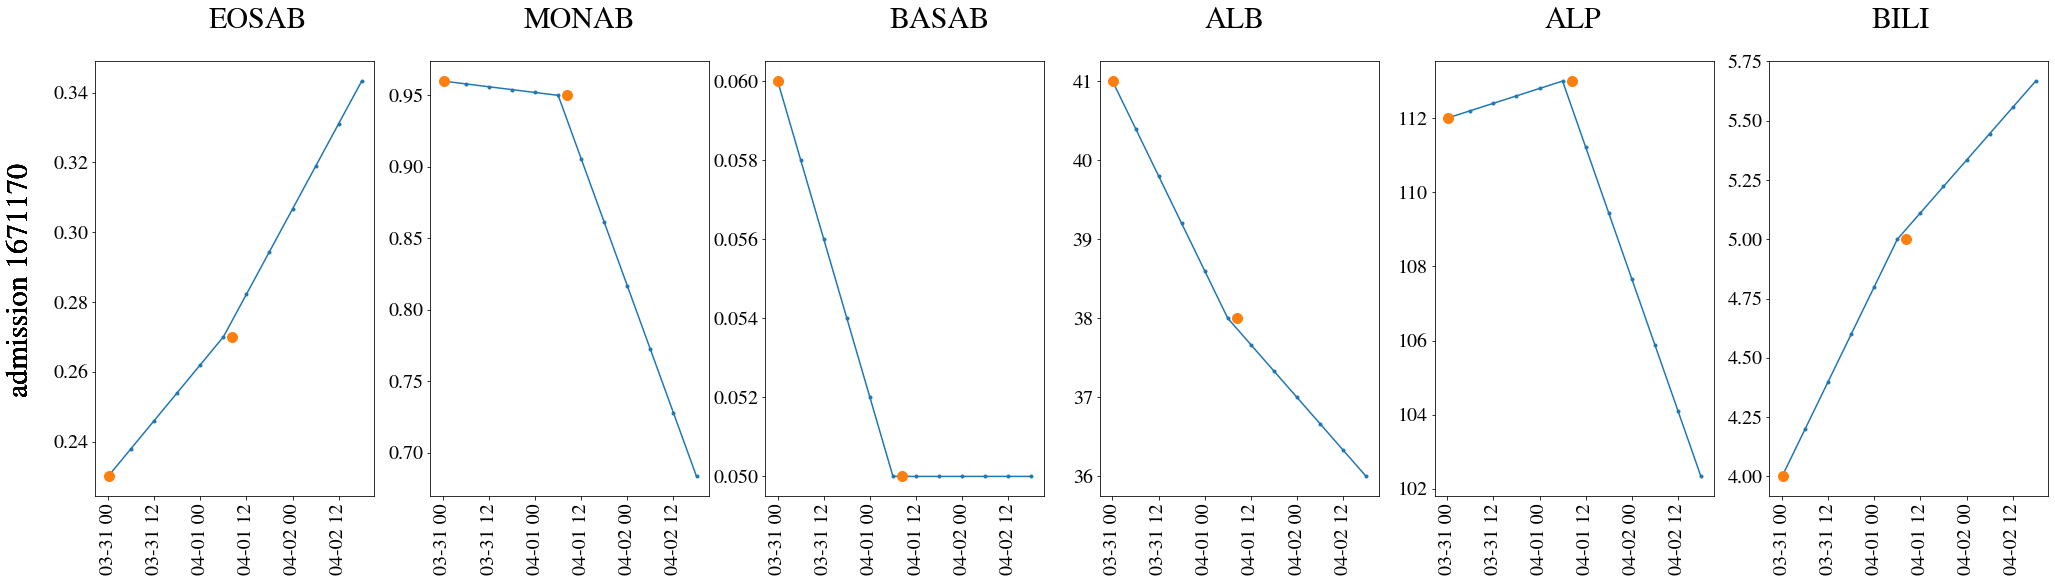

In [16]:
adm_no = 1671170
plot_eobs_admin(adm_no, dct_lbl_3, save = False)

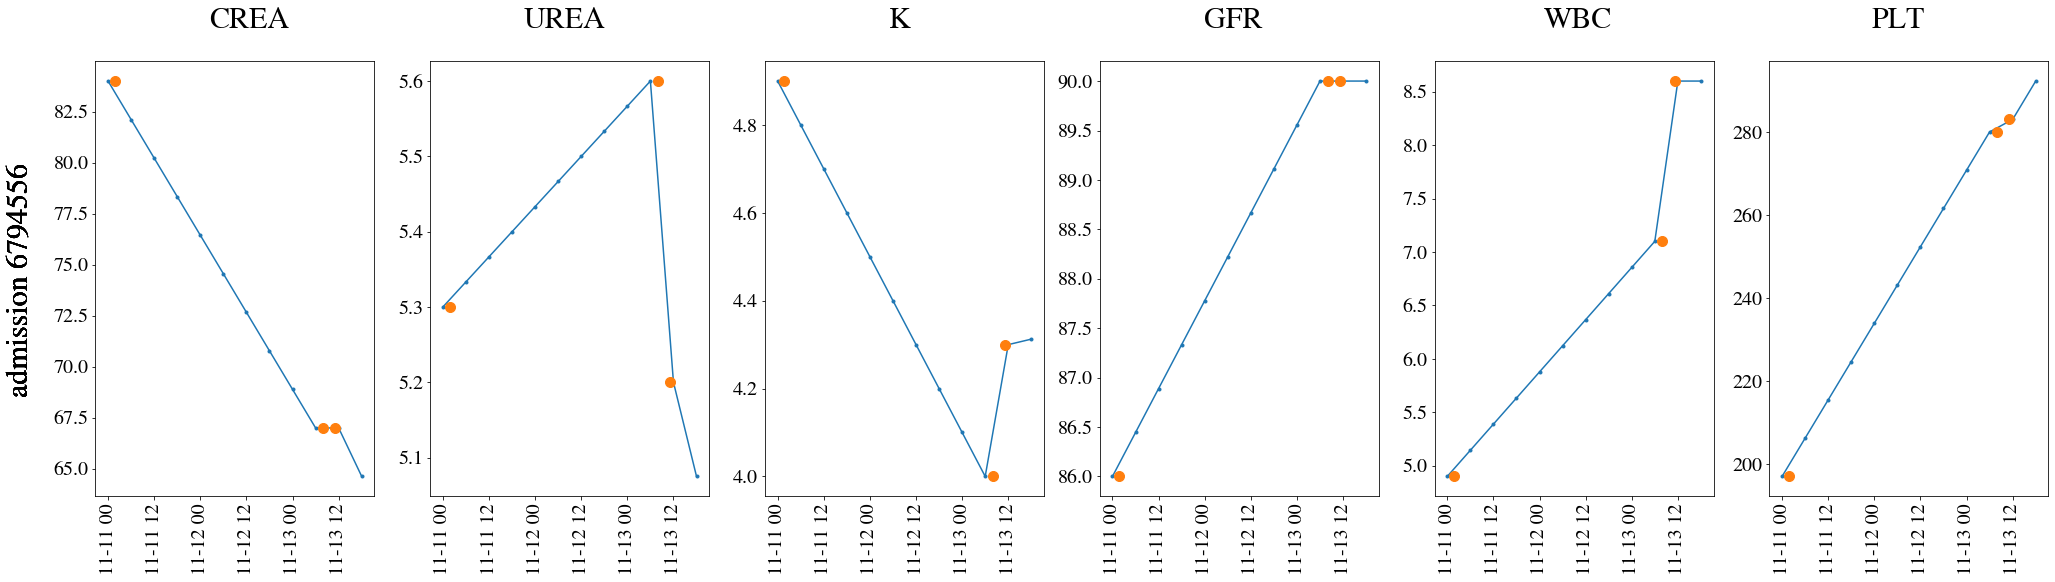

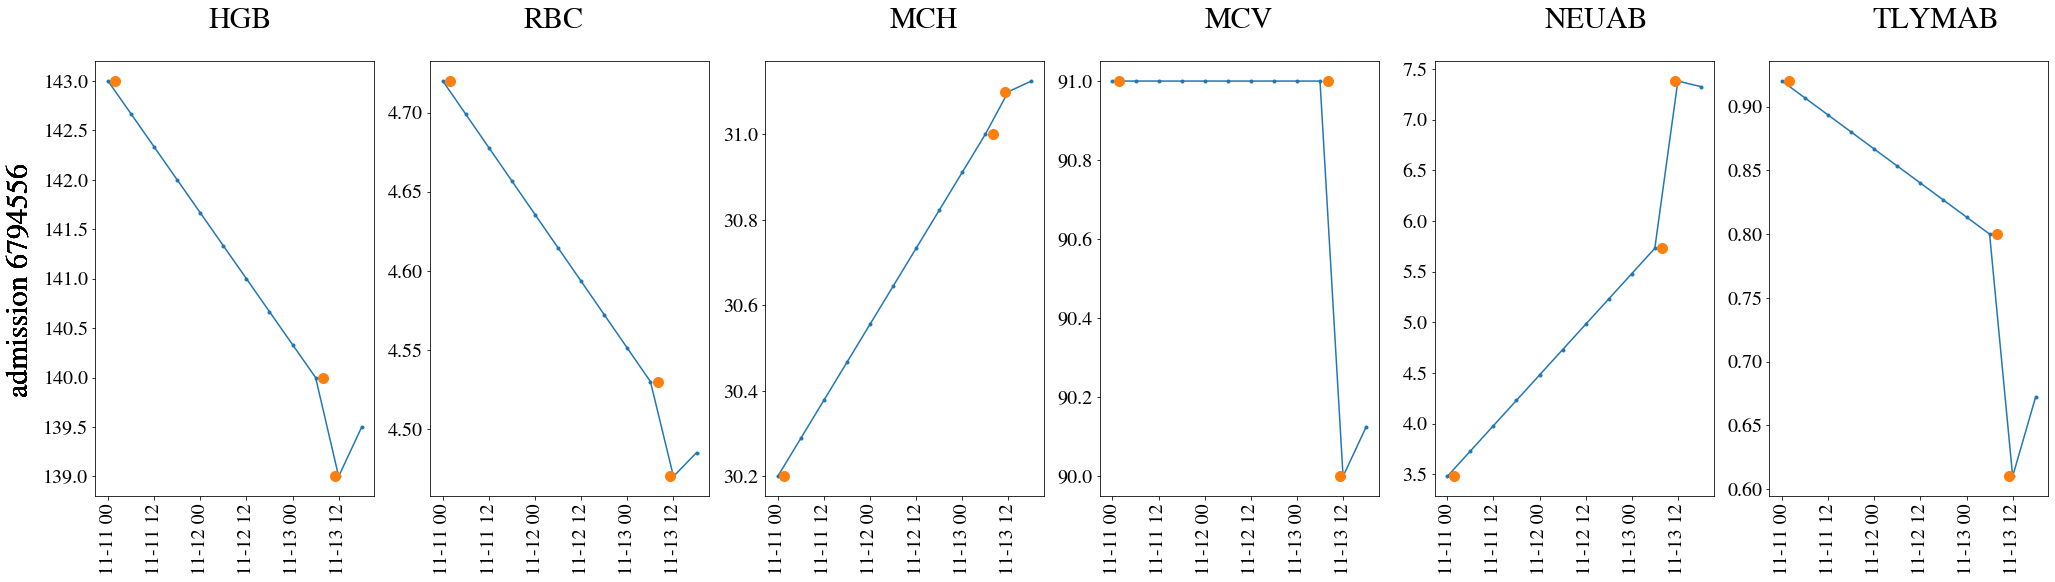

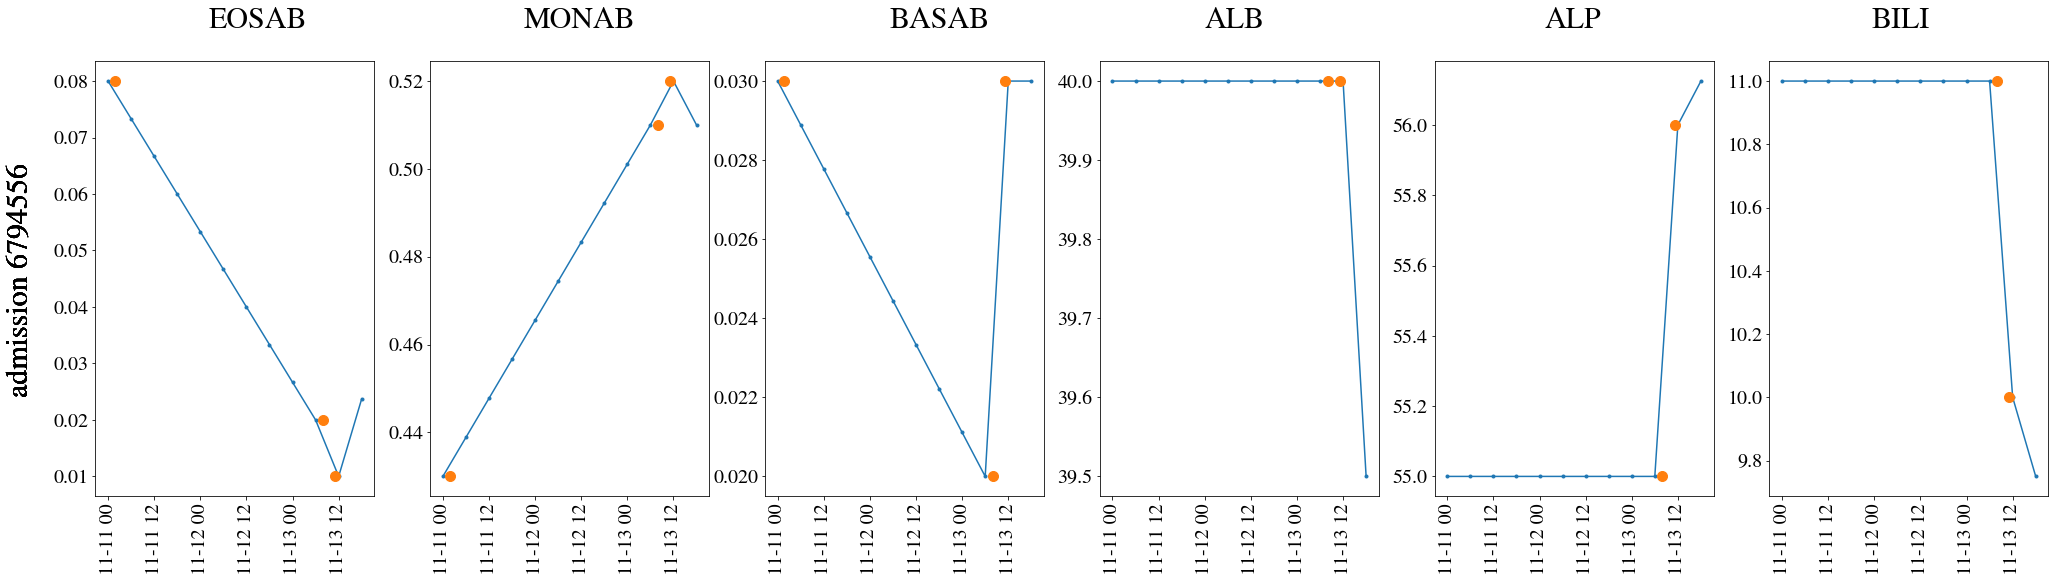

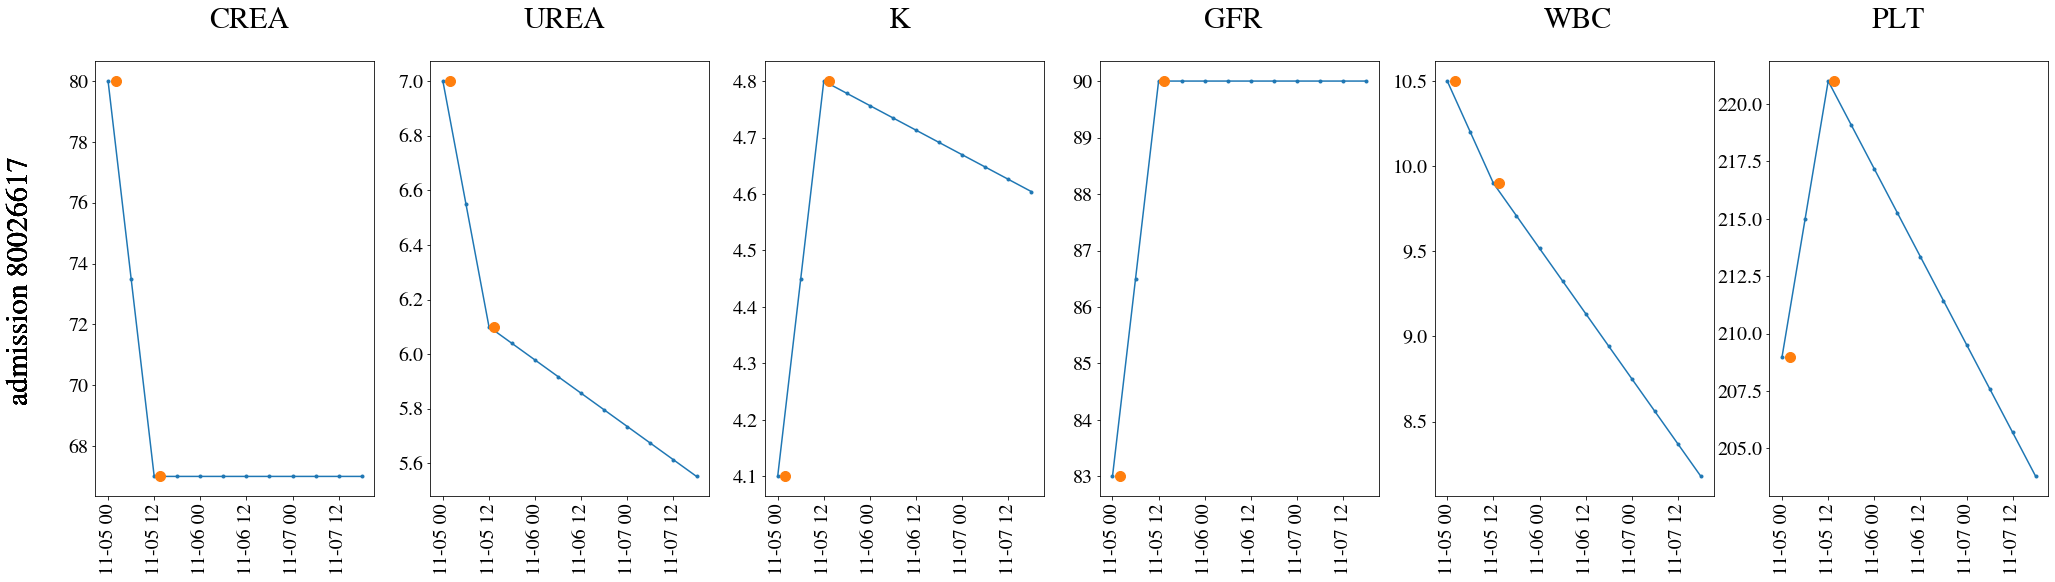

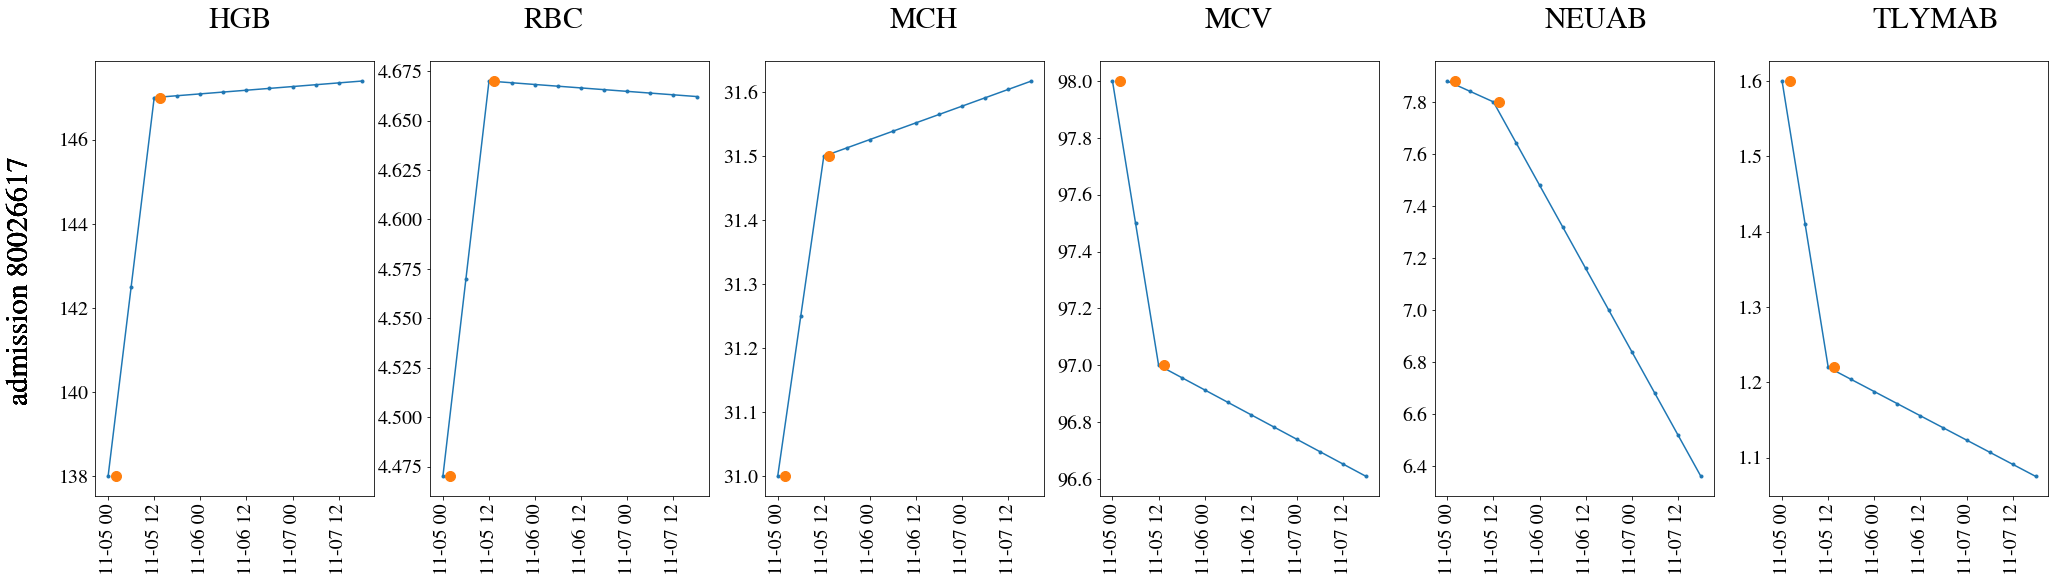

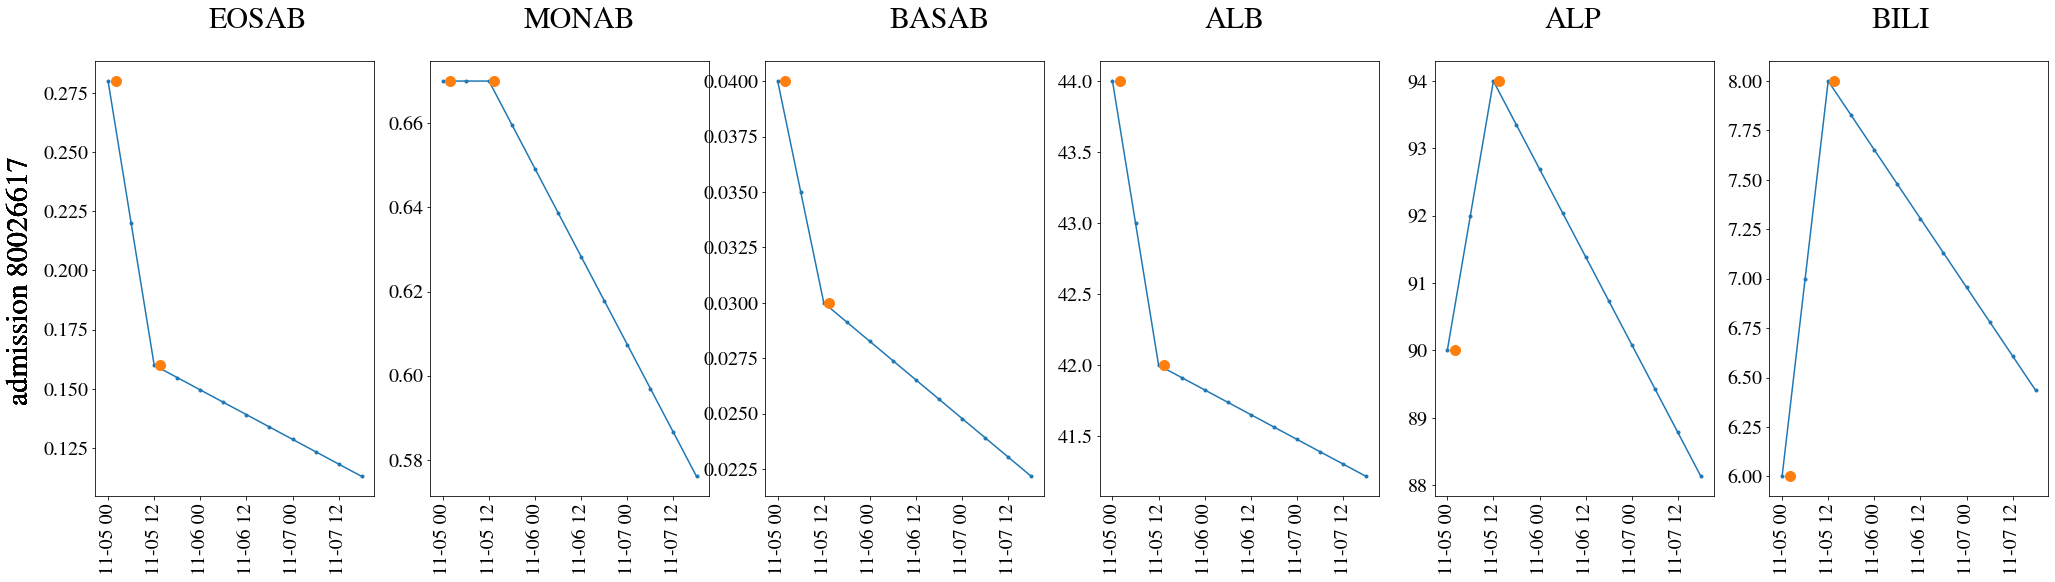

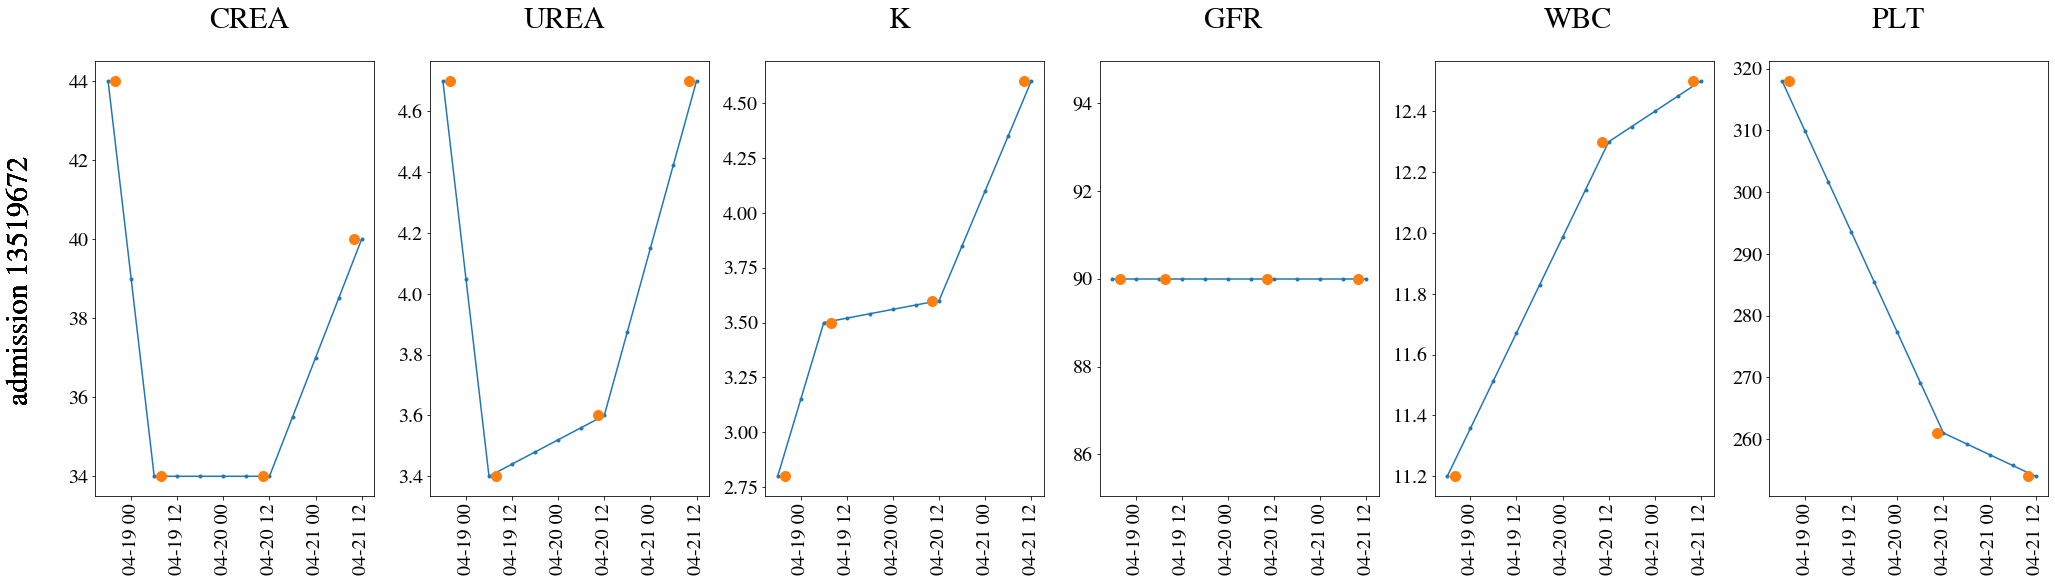

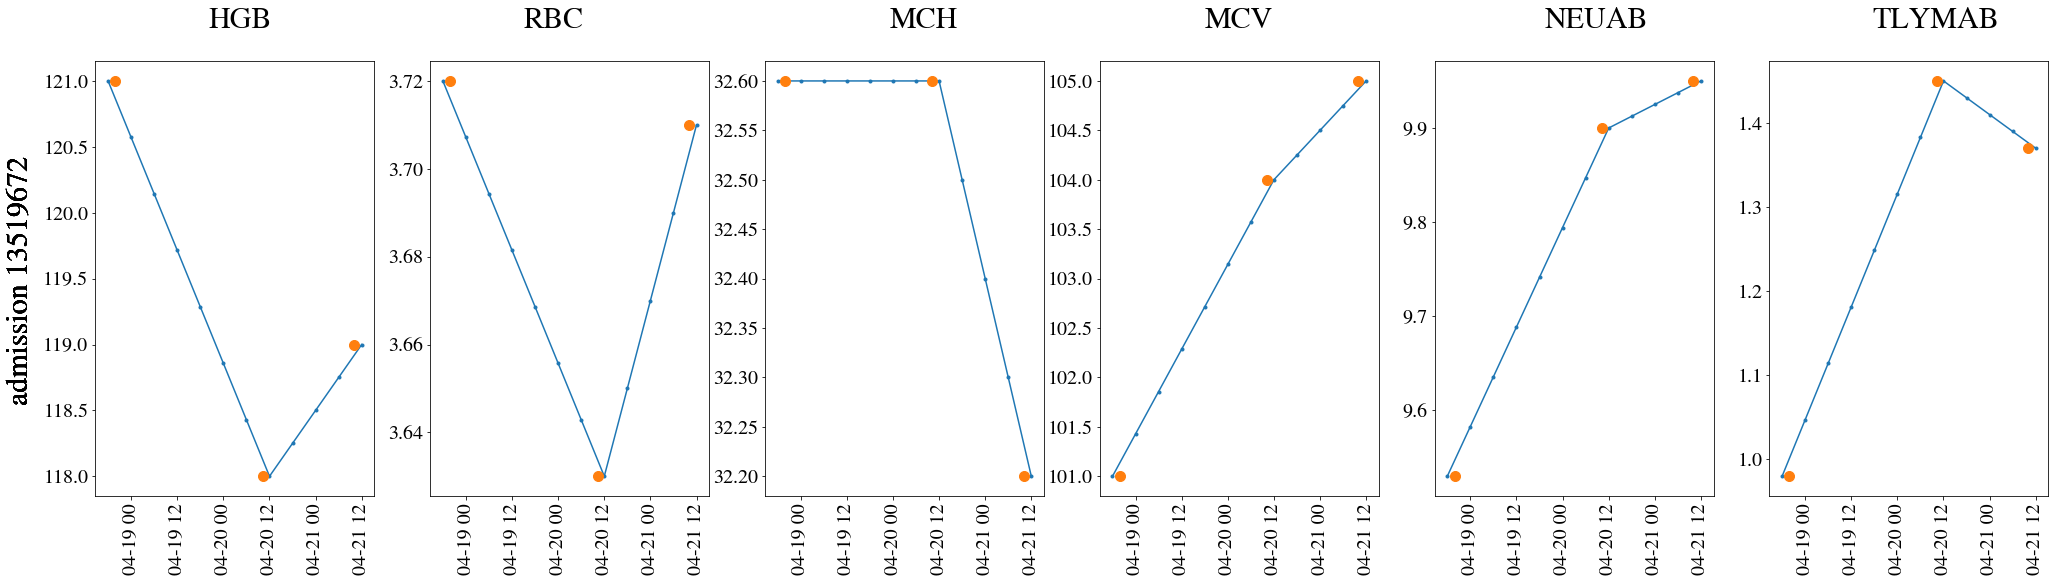

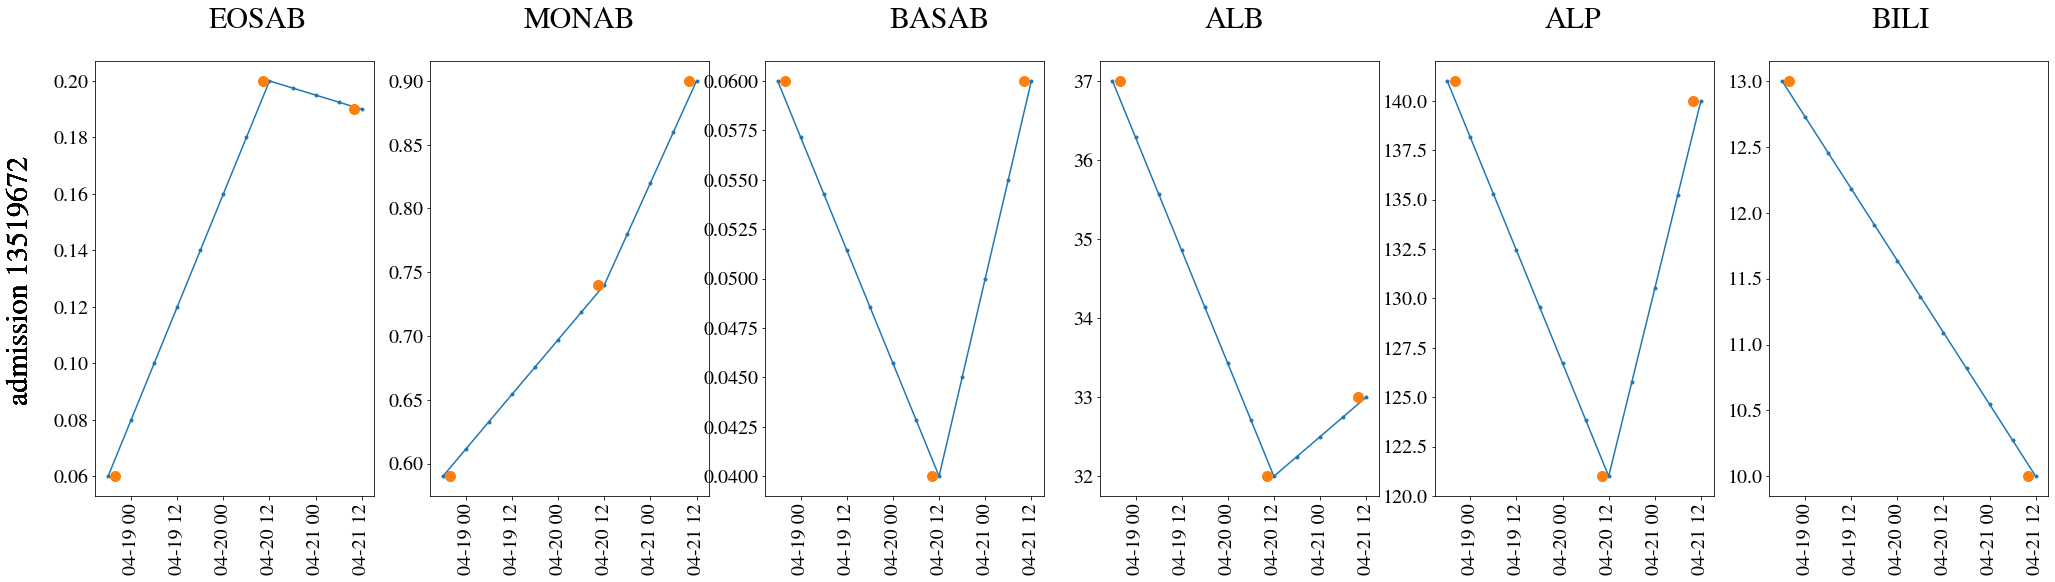

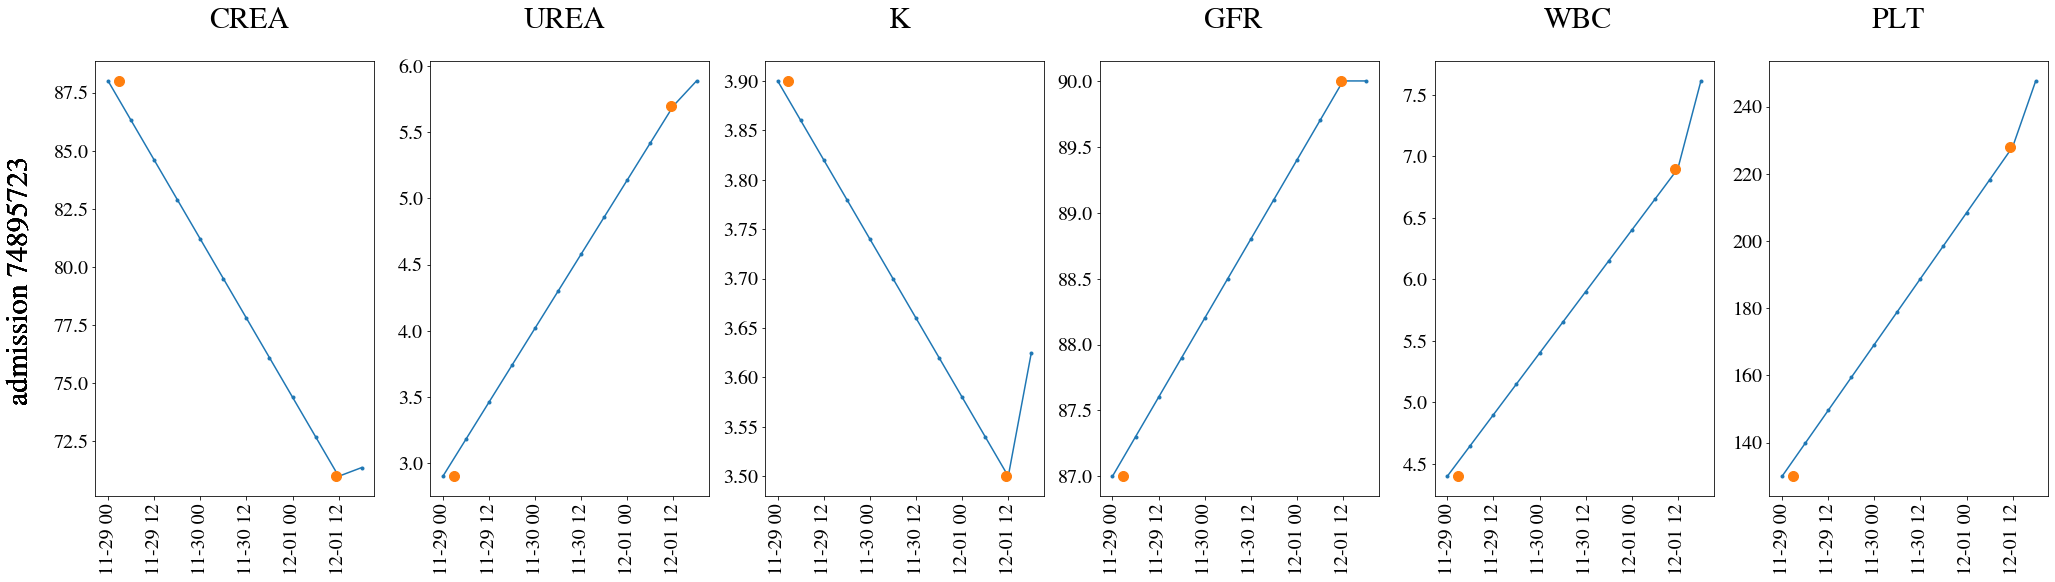

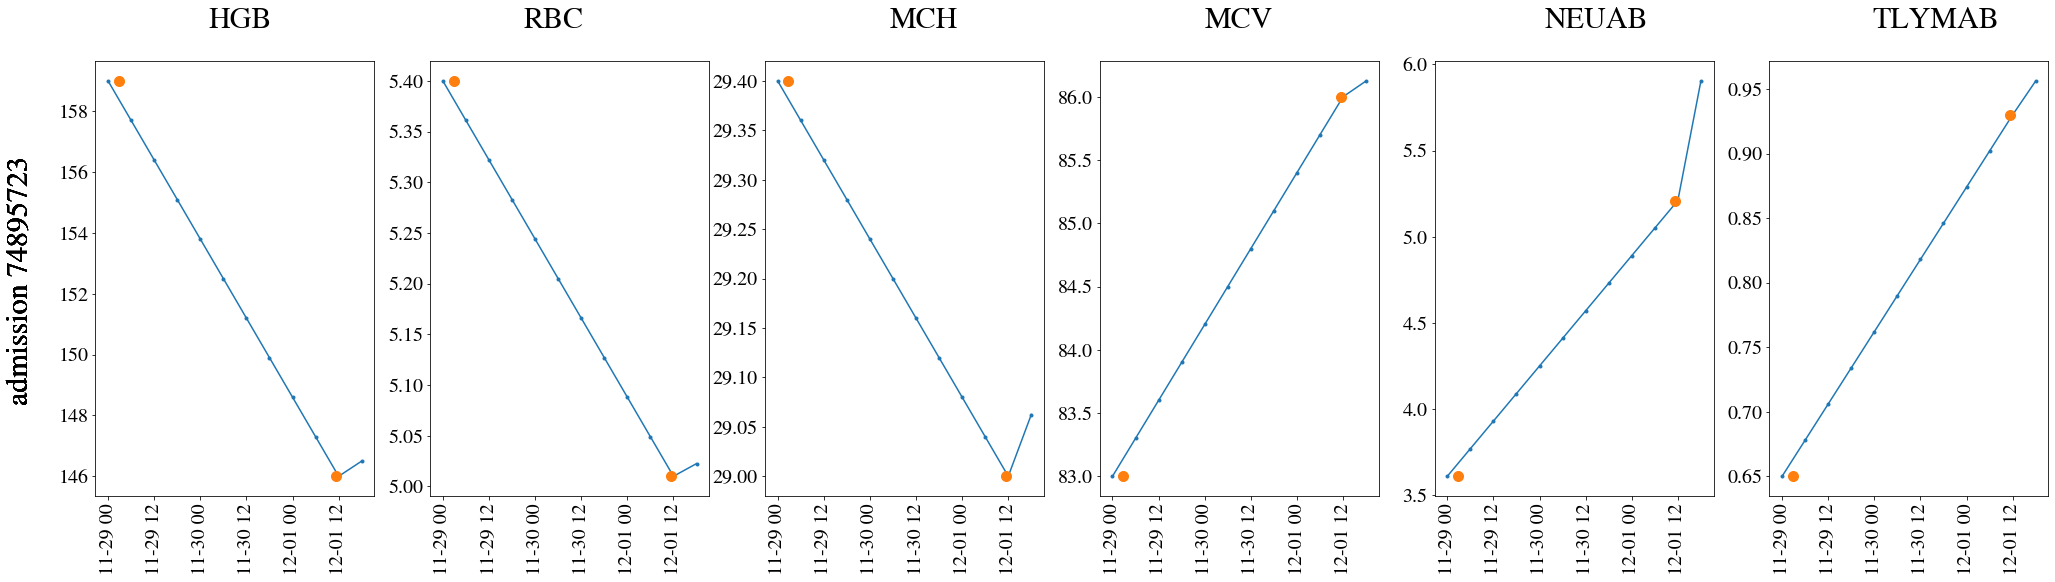

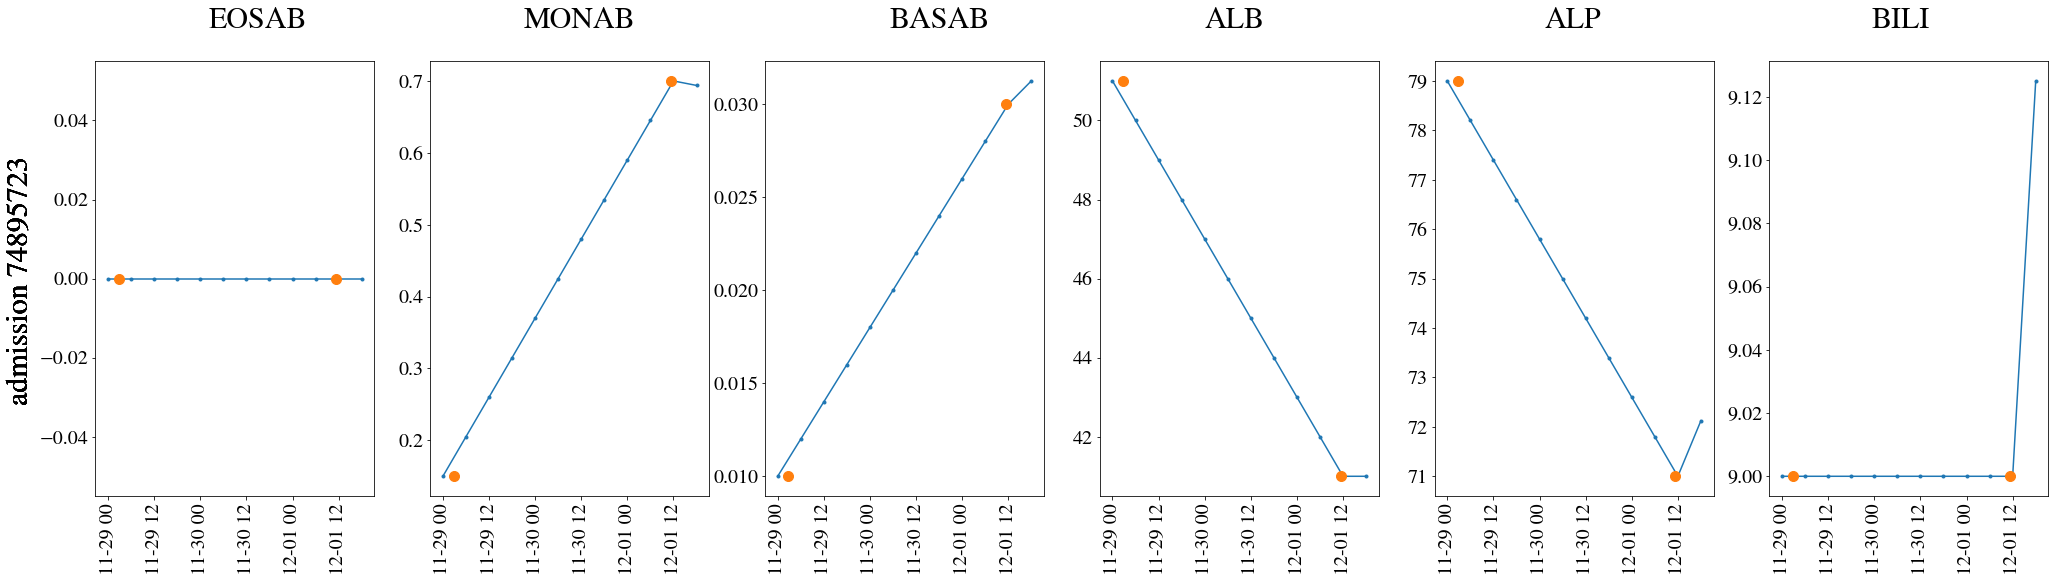

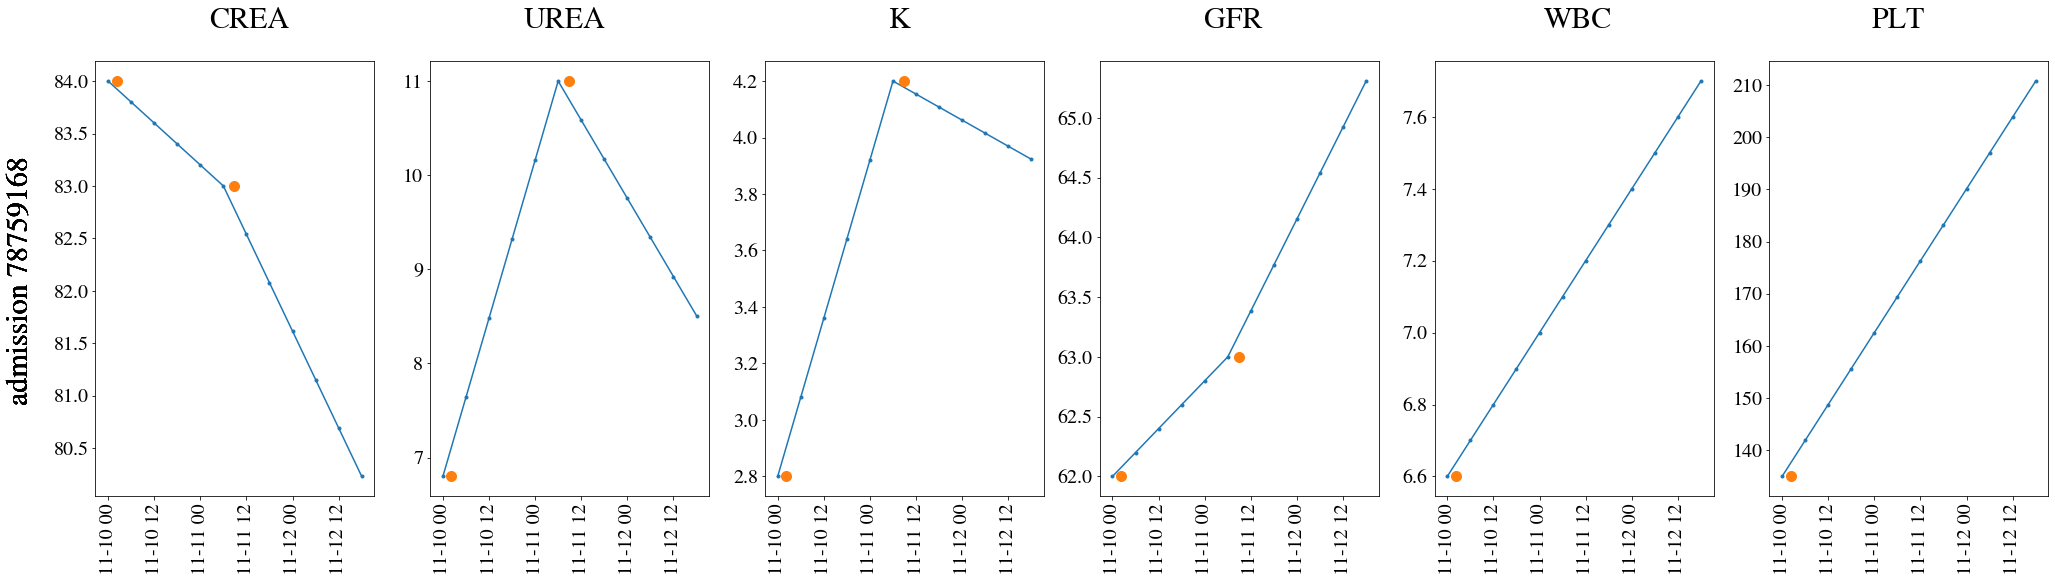

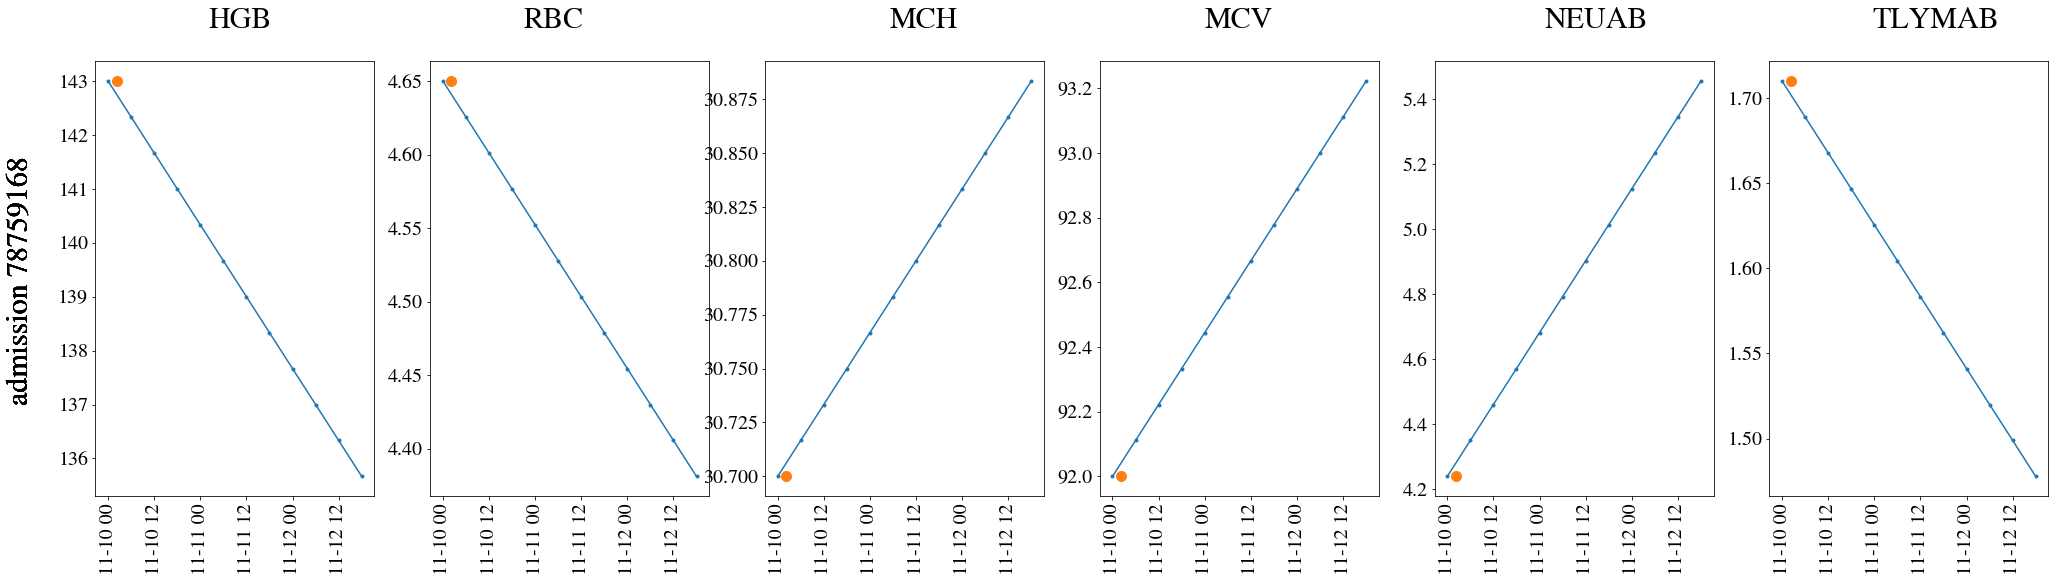

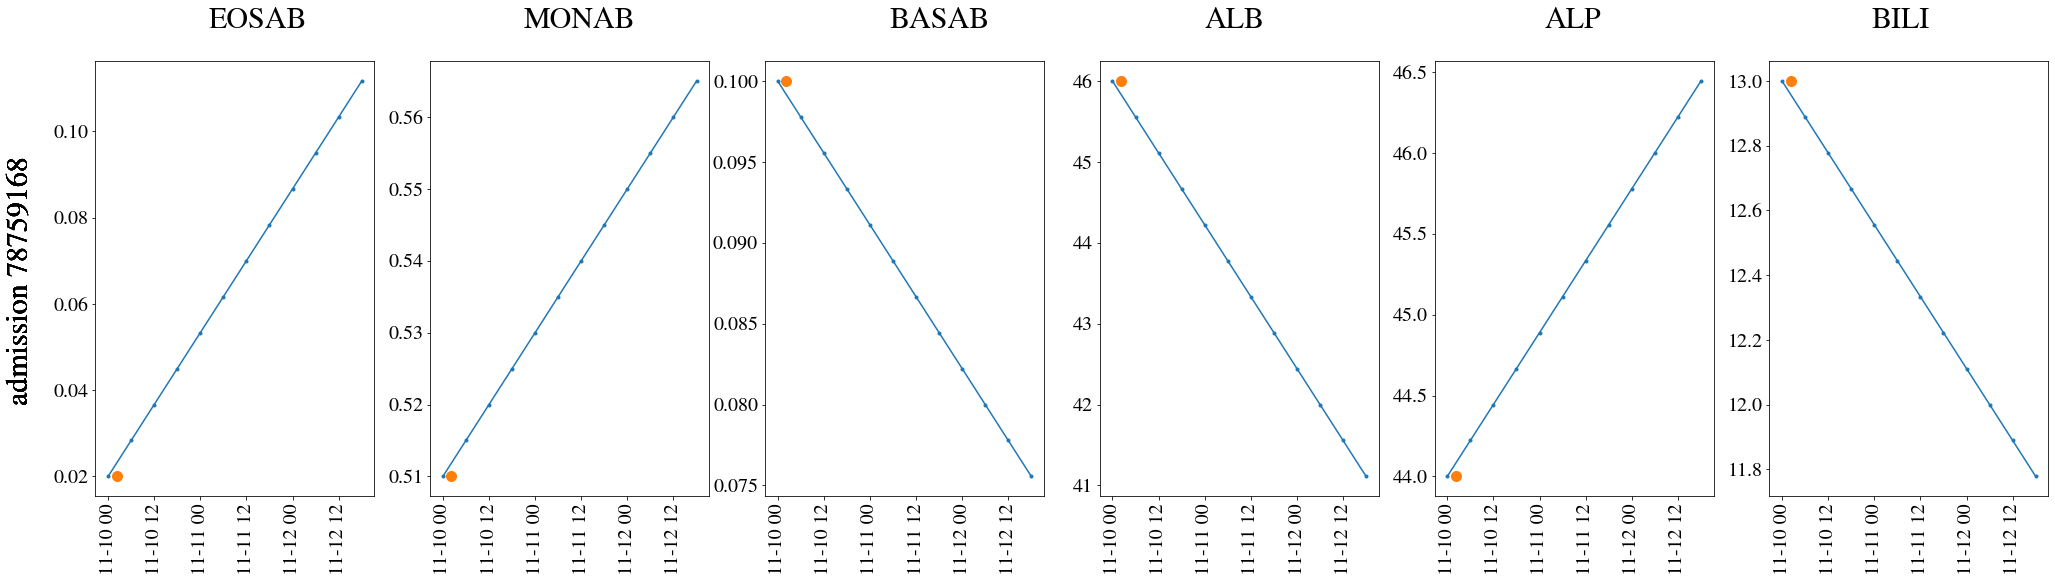

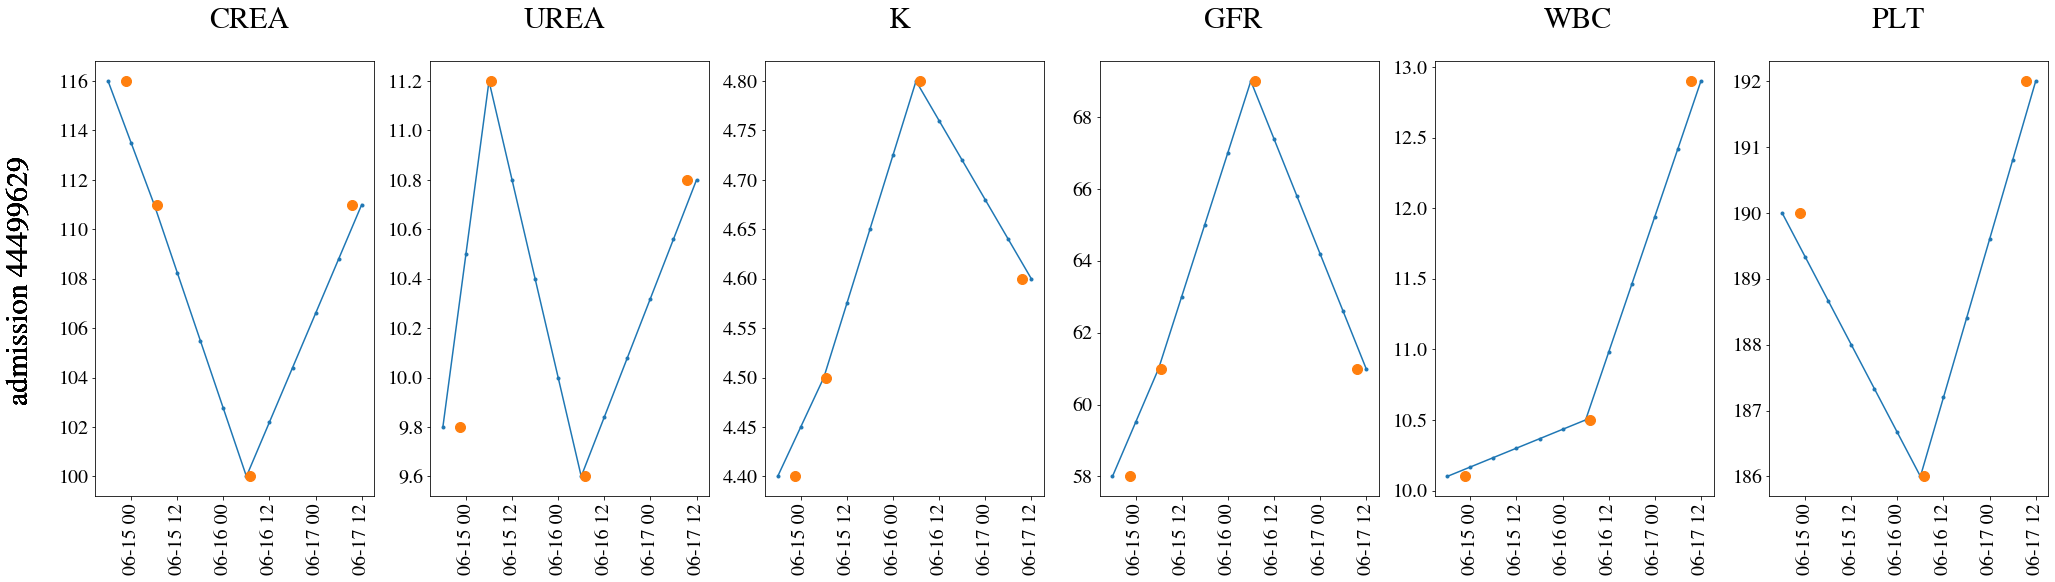

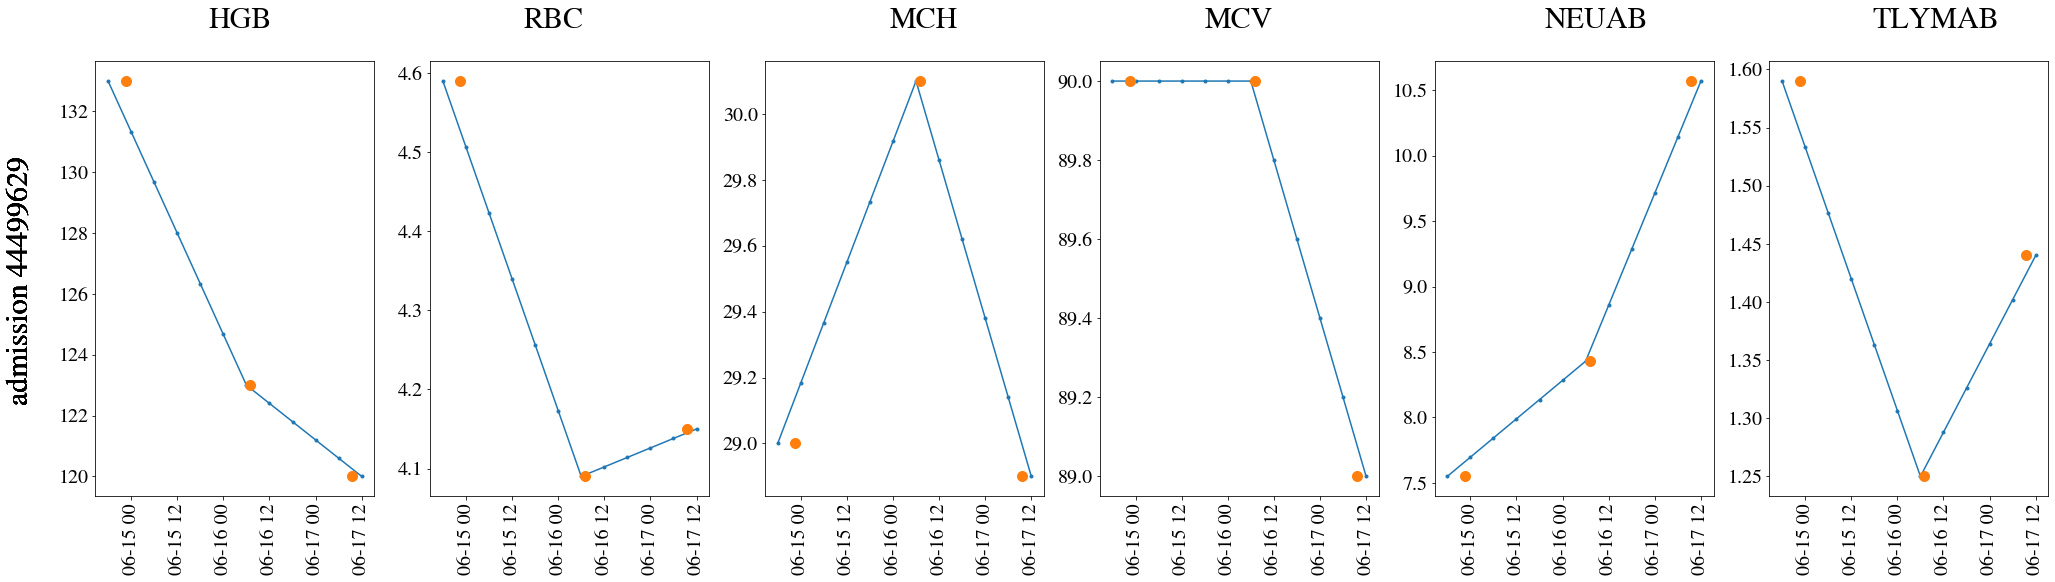

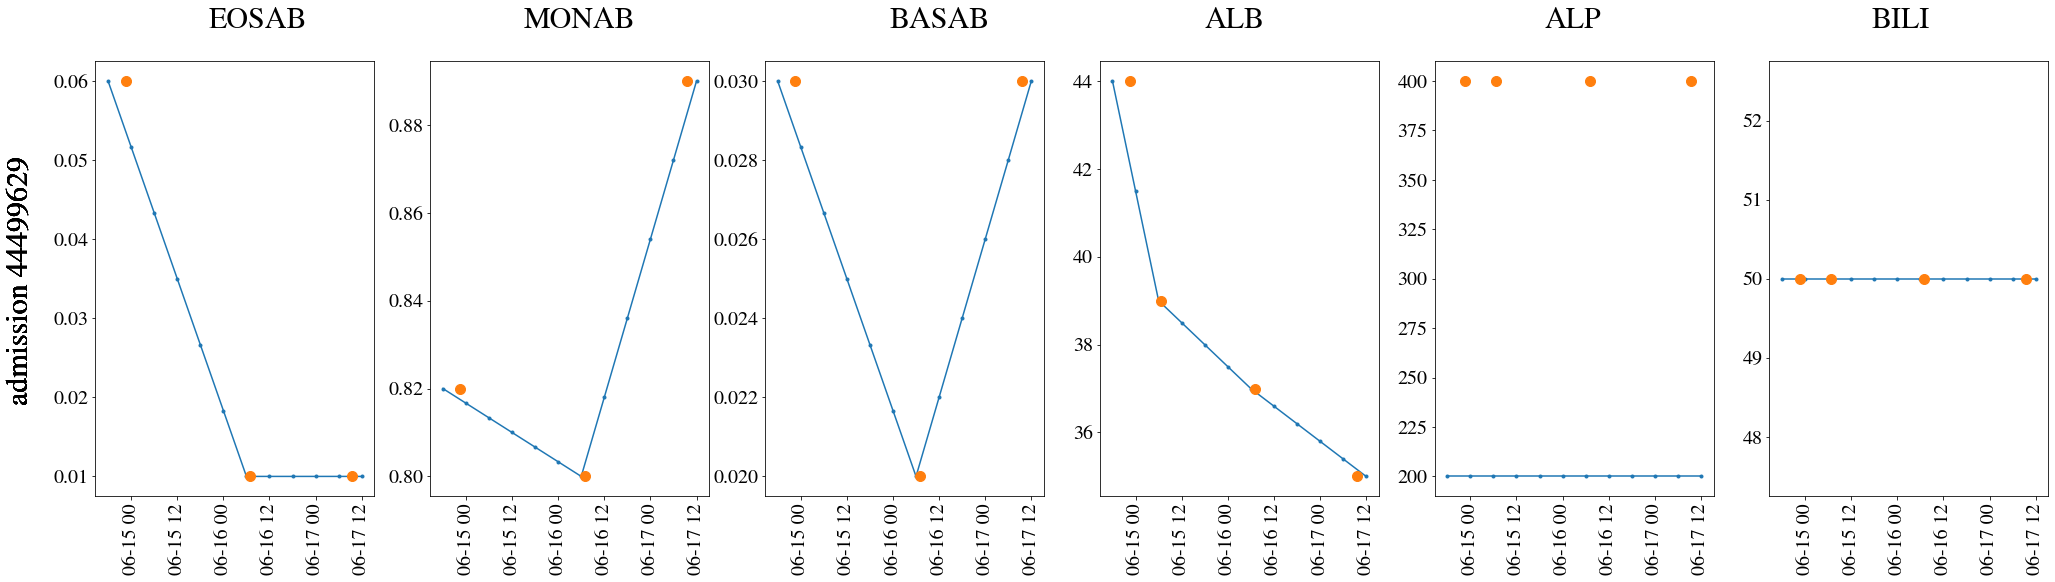

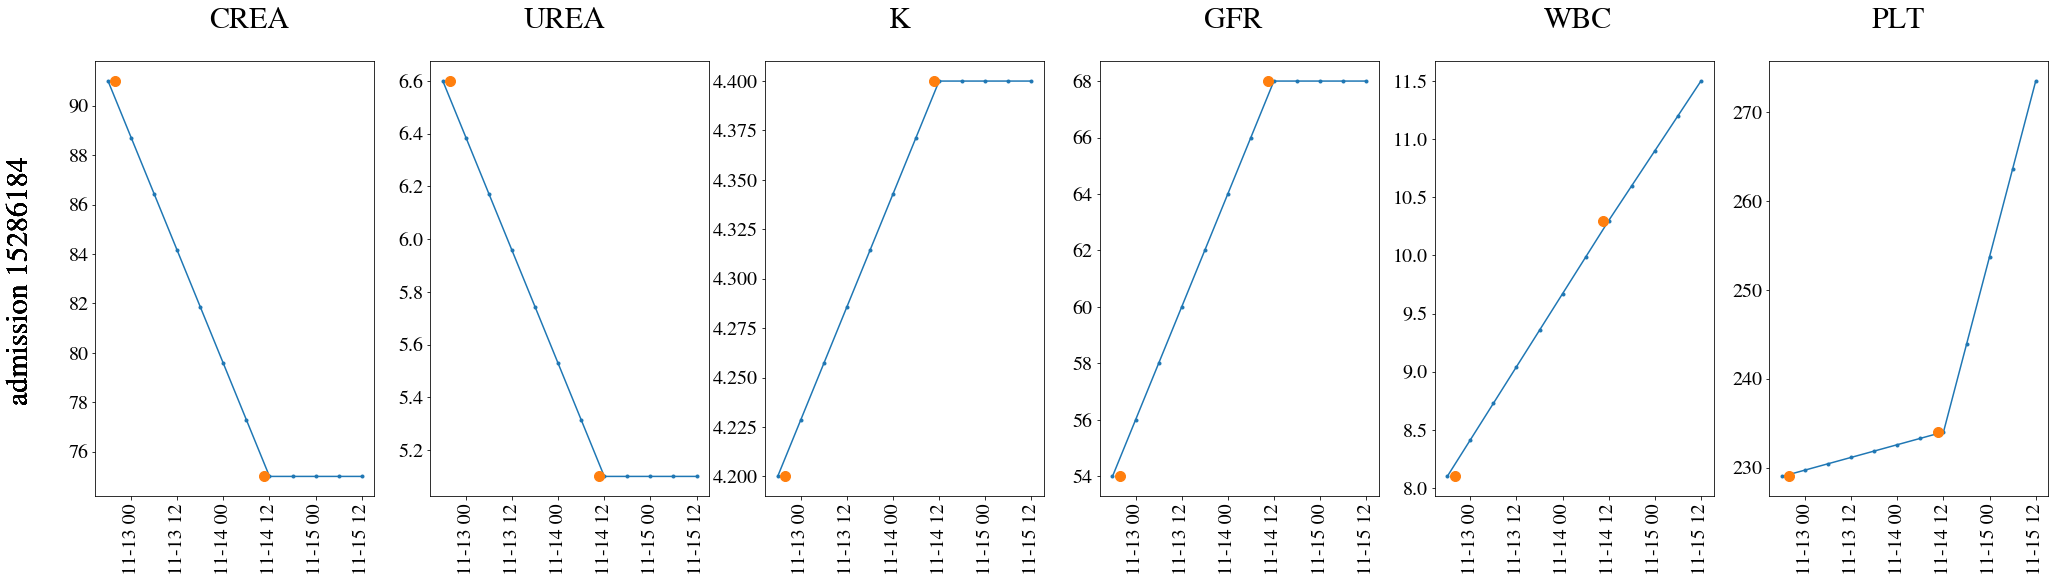

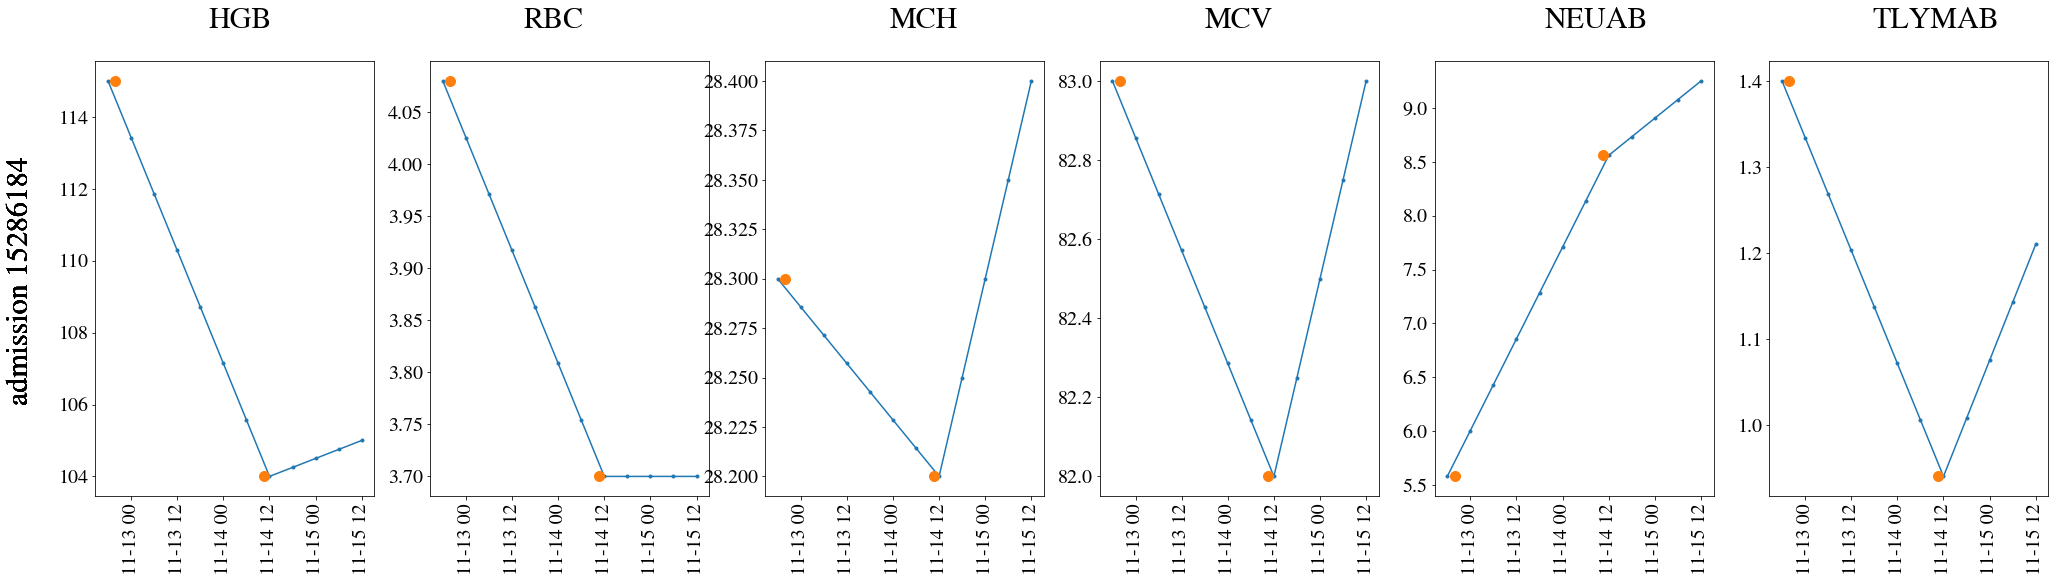

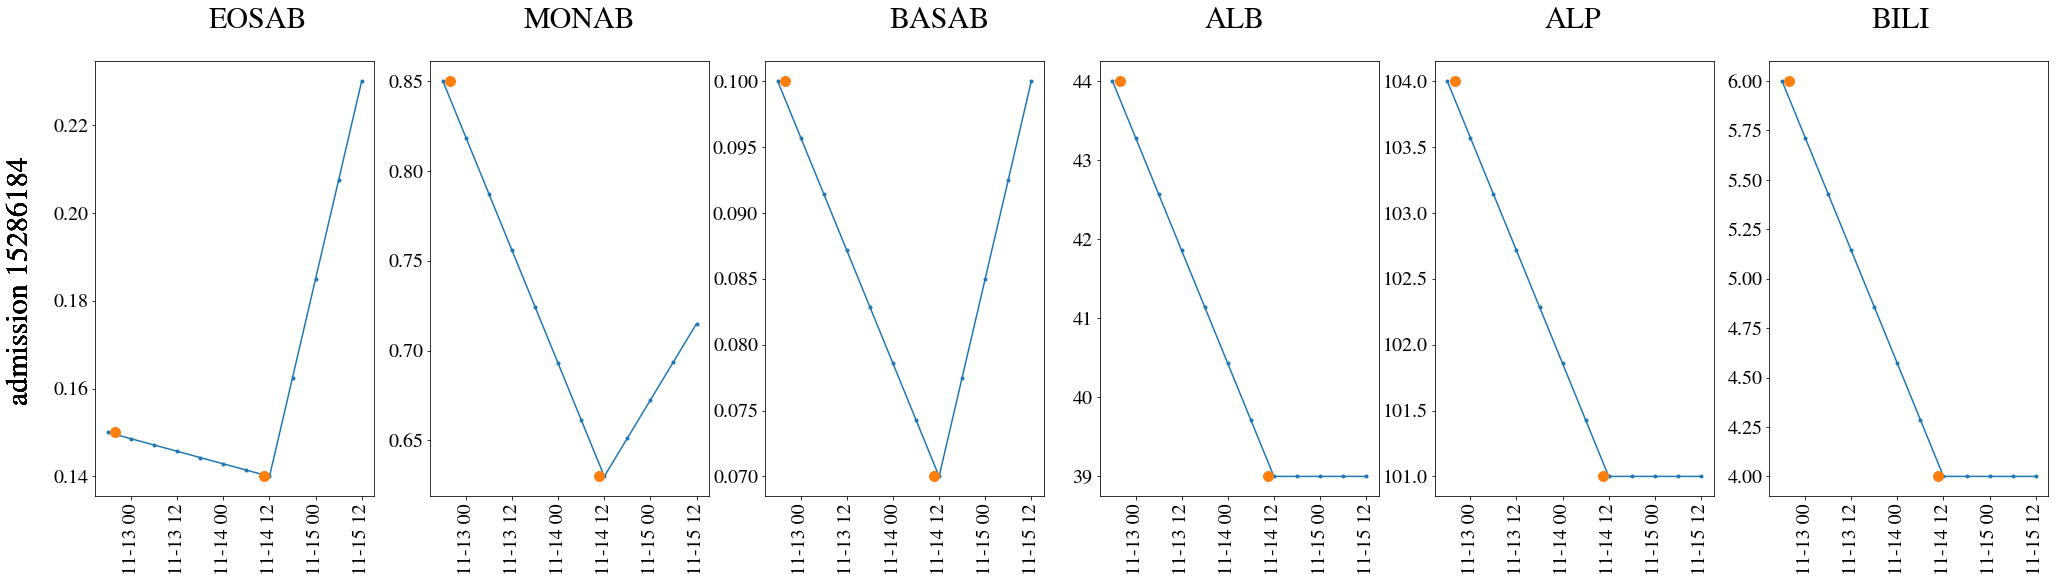

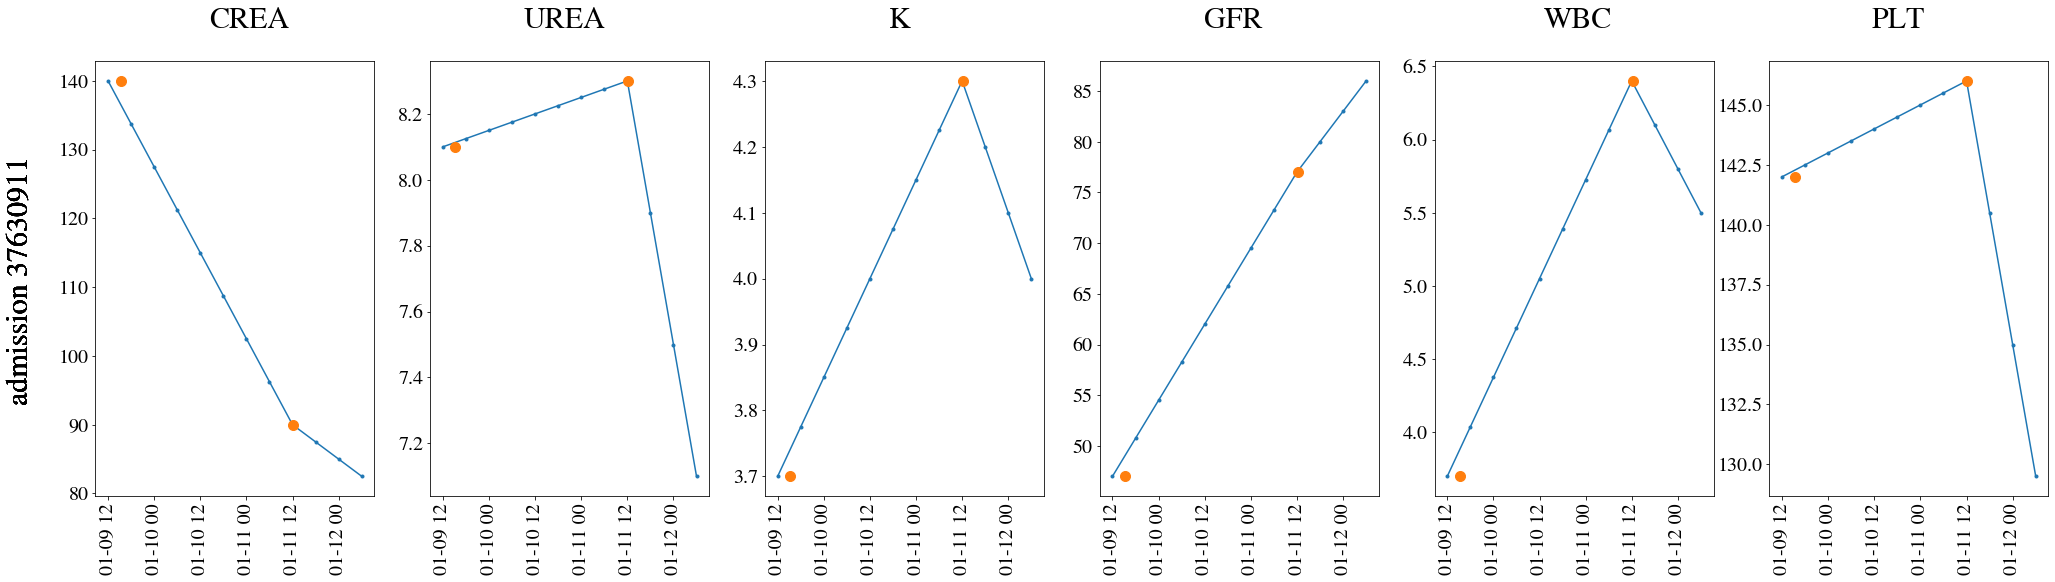

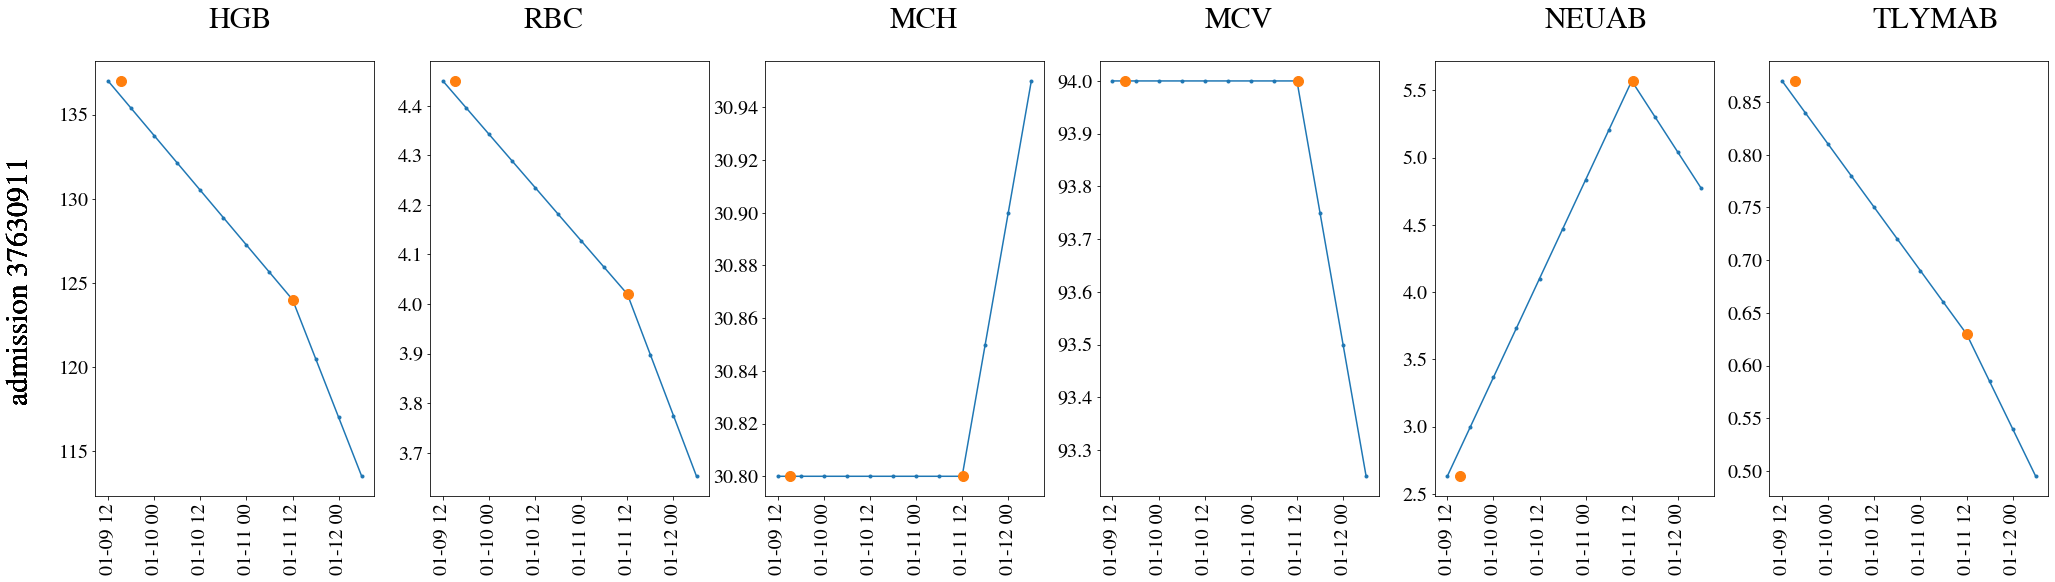

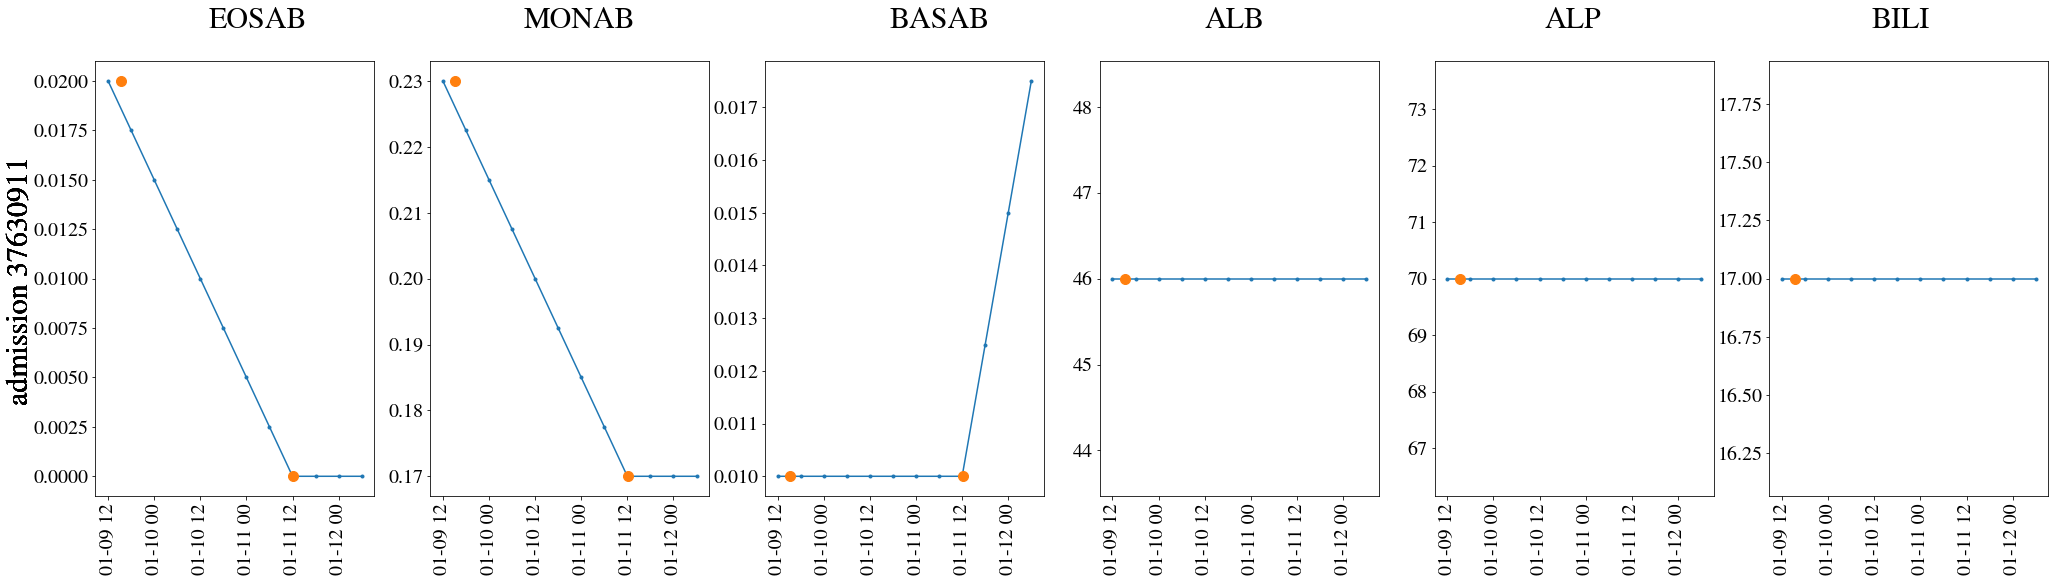

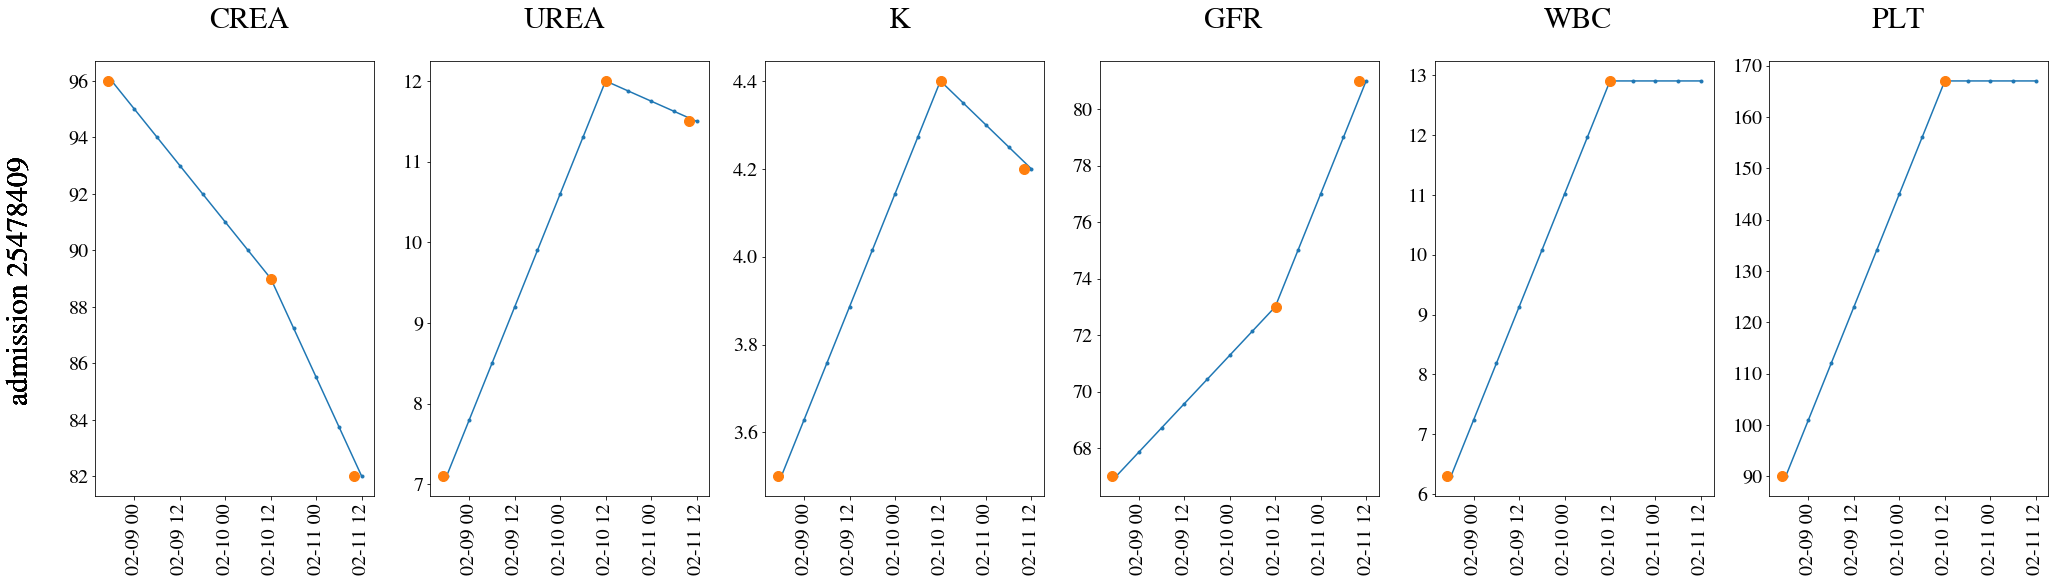

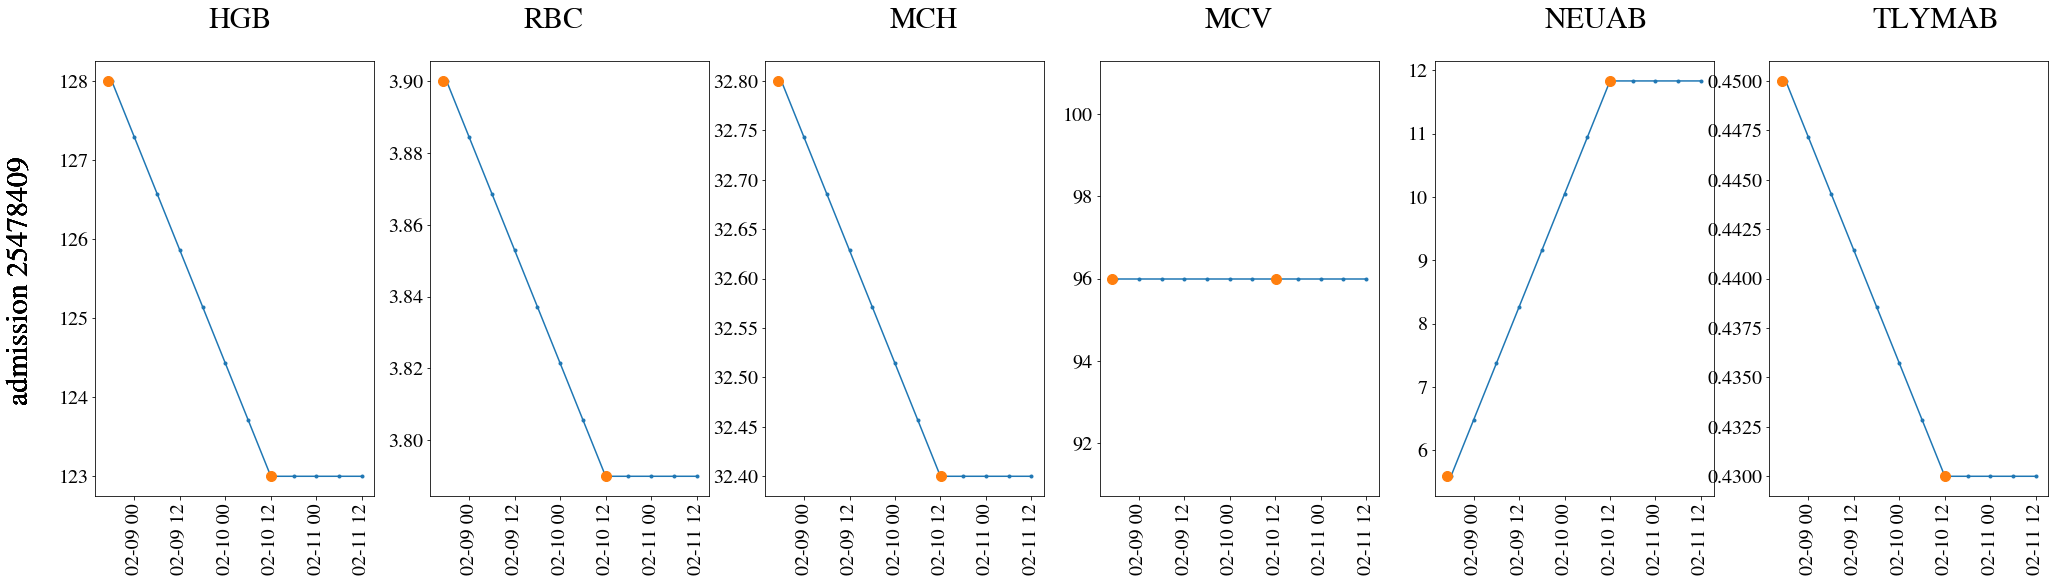

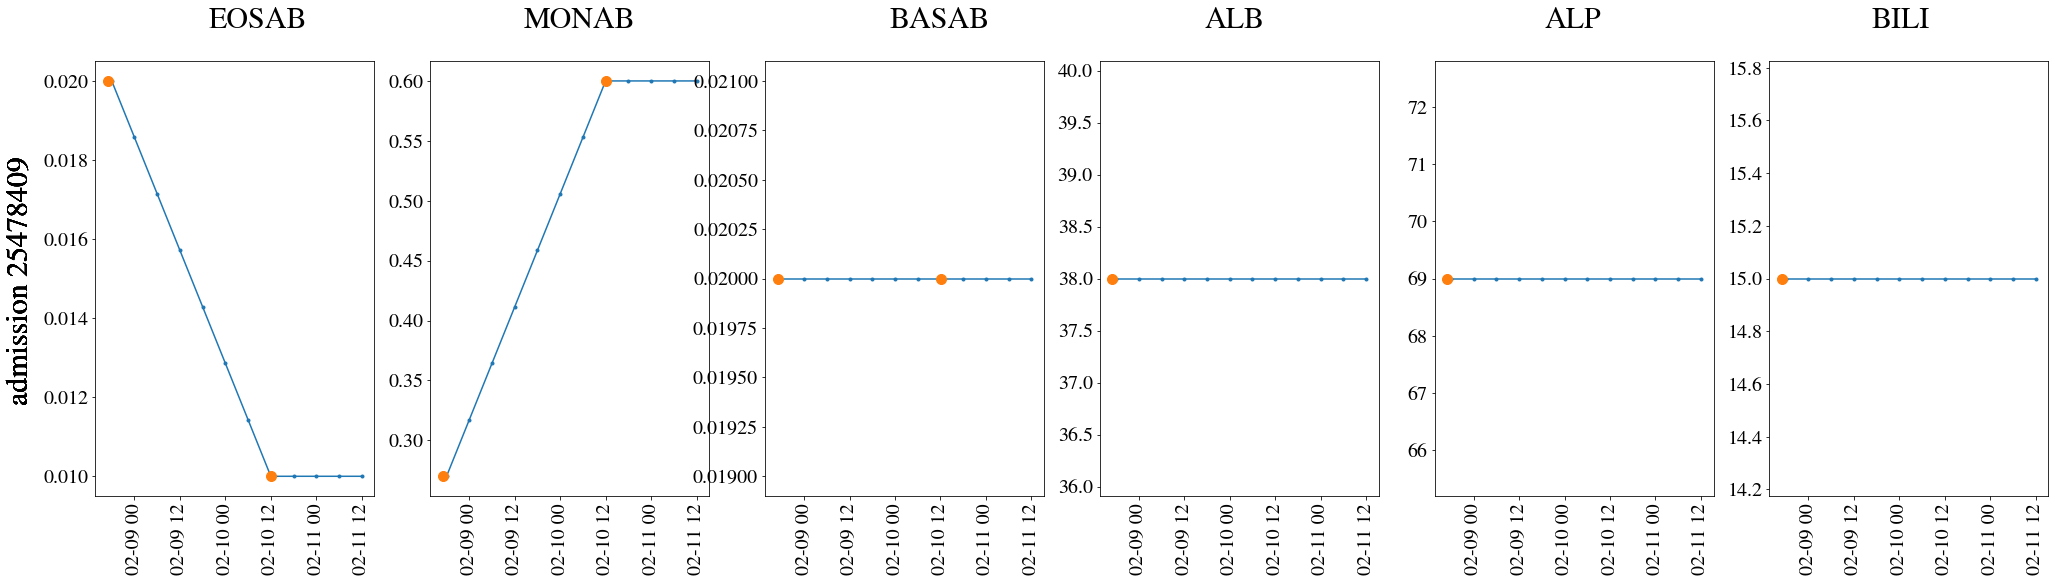

In [17]:

n_plots = 9
admns = df_haematology_new['admission_id'].unique().tolist()
idx_adm = random.sample(range(len(admns)), n_plots)

for i, idx in enumerate(idx_adm):
    adm_no = admns[idx]
    plot_eobs_admin(adm_no, dct_lbl_1, save = True)
    plot_eobs_admin(adm_no, dct_lbl_2, save = True)
    plot_eobs_admin(adm_no, dct_lbl_3, save = True)

In [18]:
len(admns)

8258

In [19]:
len(df_haematology_new)

99096